# Imports

In [1]:
import os
import sys
import pysam
import pickle
import random
import modisco
import warnings
import plotnine
import pybedtools
import numpy as np
import tabix as tb
import pandas as pd
from plotnine import *
from pandas import Series
from decimal import Decimal
from kerasAC.splits import *
from matplotlib import pyplot as plt
from deeplift.dinuc_shuffle import dinuc_shuffle

from dragonn.interpret import * 
from dragonn.vis import *
from dragonn.utils import *

sys.path.insert(0, "/users/soumyak/alzheimers_parkinsons/clusters_gkmsvm")
from viz_preprocess import *
from viz_sequence import *

np.random.seed(1234)
plt.style.use('default')
pd.set_option('display.max_columns', None)

TF-MoDISco is using the TensorFlow backend.
Using TensorFlow backend.


# Quick Links

<ol>
    <li><a href=#effect_table>Effect Alleles Table</a></li>
    <li><a href=#effect_viz>Effect Alleles Visual</a></li>
    <li><a href=#noneffect_table>Non-Effect Alleles Table</a></li>
    <li><a href=#noneffect_viz>Non-Effect Alleles Visual</a></li>
</ol>

# Cluster 12

In [2]:
cluster = '12'

## Prepare Effect and Non-Effect Scores

In [3]:
effect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster'+cluster+'.effect.fasta'
effect_seqs = [x.rstrip() for (i,x) in enumerate(open(effect_fasta)) if i%2==1]
effect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in effect_seqs]

print("Num effect sequences:", len(effect_onehot))

merged_effect_scores = np.zeros(shape=(len(effect_onehot), 1000, 4))

for fold in range(10):
    effect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster'+cluster+'/fold'+str(fold)+'.effect.scores.txt'
    effect_scores = get_hyp_scores(effect_file, effect_seqs)
    effect_scores = np.array(effect_scores)
    merged_effect_scores = merged_effect_scores + effect_scores
    
merged_effect_scores = merged_effect_scores / (fold + 1)

#--------------------------------------------------------#

noneffect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster'+cluster+'.noneffect.fasta'
noneffect_seqs = [x.rstrip() for (i,x) in enumerate(open(noneffect_fasta)) if i%2==1]
noneffect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in noneffect_seqs]

print("Num noneffect sequences:", len(noneffect_onehot))

merged_noneffect_scores = np.zeros(shape=(len(noneffect_onehot), 1000, 4))

for fold in range(10):
    noneffect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster'+cluster+'/fold'+str(fold)+'.noneffect.scores.txt'
    noneffect_scores = get_hyp_scores(noneffect_file, noneffect_seqs)
    noneffect_scores = np.array(noneffect_scores)
    merged_noneffect_scores = merged_noneffect_scores + noneffect_scores
    
merged_noneffect_scores = merged_noneffect_scores / (fold + 1)

#--------------------------------------------------------#

merged_ism_scores = np.zeros(shape=(len(effect_onehot),))
merged_delta_scores = np.zeros(shape=(len(effect_onehot),))

for fold in range(10):
    ism_scores = np.array([float(i.strip().split('\t')[1]) for i in open('/mnt/lab_data3/soumyak/adpd/ism_scores/Cluster'+cluster+'/fold'+str(fold)+'.ism.scores').readlines()])
    delta_scores = np.array([float(i.strip().split('\t')[1]) for i in open('/mnt/lab_data3/soumyak/adpd/delta_scores/Cluster'+cluster+'/fold'+str(fold)+'.delta.scores').readlines()])
    merged_ism_scores = merged_ism_scores + ism_scores
    merged_delta_scores = merged_delta_scores + delta_scores
        
merged_ism_scores = merged_ism_scores / (fold + 1)
merged_delta_scores = merged_delta_scores / (fold + 1)

Num effect sequences: 320
Num noneffect sequences: 320


## Prepare DataFrame

In [4]:
snps = pd.read_csv('/mnt/lab_data3/soumyak/adpd/snp_lists/Cluster'+cluster+'.overlap.expanded.snps.hg38.bed', sep='\t')
ryan_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snps_final/191023_All_GWAS_SNPs_unique.csv', sep='\t')
mike_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snps_final/ld_buddies_table_stage3.tsv', sep='\t')
effect_score = []
noneffect_score = []
effect_center = []
noneffect_center = []
effect_ratio = []
noneffect_ratio = []
allele_ratio = []
allele_diff = []
effect_rank = []
noneffect_rank = []
ism_score = []
delta_score = []
idr_peak = []
all_gwas = []
coloc = []
for index,row in snps.iterrows():
    effect_score.append(np.sum(np.array([np.sum(j) for j in merged_effect_scores[index][400:600]])))
    noneffect_score.append(np.sum(np.array([np.sum(j) for j in merged_noneffect_scores[index][400:600]])))
    effect_center.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][475:525]])))
    noneffect_center.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][475:525]])))
    effect_ratio.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][475:525]])) / np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][400:600]])))
    noneffect_ratio.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][475:525]])) / np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][400:600]])))
    allele_ratio.append(effect_center[-1] / (noneffect_center[-1] + 0.00001))
    #allele_diff.append(effect_center[-1] - noneffect_center[-1])
    allele_diff.append(np.sum(np.array([np.sum(j) for j in merged_effect_scores[index][475:525]])) - np.sum(np.array([np.sum(j) for j in merged_noneffect_scores[index][475:525]])))
    effect_rank.append((effect_center[-1] / (noneffect_center[-1] + 0.00001)) * effect_ratio[-1])
    noneffect_rank.append((noneffect_center[-1] / (effect_center[-1] + 0.00001)) * noneffect_ratio[-1])
    idr_peak_overlap = False
    for ind,rw in ryan_snps.loc[ryan_snps['rsid']==row['rsid']].iterrows():
        if rw['Cluster'+cluster+'_overlap'] == 1:
            idr_peak_overlap = True
    idr_peak.append(idr_peak_overlap)
    gwas_list = []
    has_coloc = False
    for ind,rw in mike_snps.loc[mike_snps['rsid']==row['rsid']].iterrows():
        gwas_list.append(rw['source_gwas']+': '+str('%.2E' % Decimal(rw['pvalue'])))
        if rw['has_coloc'] == True:
            has_coloc = True
    all_gwas.append(gwas_list)
    coloc.append(has_coloc)
snps['effect_score'] = effect_score
snps['noneffect_score'] = noneffect_score
snps['effect_center'] = effect_center
snps['noneffect_center'] = noneffect_center
snps['effect_ratio'] = effect_ratio
snps['noneffect_ratio'] = noneffect_ratio
snps['allele_ratio'] = allele_ratio
snps['allele_diff'] = allele_diff
snps['effect_rank'] = effect_rank
snps['noneffect_rank'] = noneffect_rank
snps['ism_score'] = merged_ism_scores
snps['delta_score'] = merged_delta_scores
snps['idr_peak'] = idr_peak
snps['all_gwas'] = all_gwas
snps['coloc'] = coloc
snps.sort_values(by=['allele_ratio'], ascending=True, inplace=True)
snps.drop_duplicates(subset=['rsid'], inplace=True)

## Find Effect Alleles that Break Accessibility <a name='effect_table' />

In [5]:
neg_snps = snps.loc[snps['allele_ratio'] <= 1]
neg_snps.sort_values(by=['noneffect_rank'], ascending=False, inplace=True)
display(neg_snps)

chr      start        end         rsid effect noneffect ref    alt  \
220  chr19   45326123   45326124     rs344792      A         G   G      A   
311   chr8   27369272   27369273     rs755951      A         C   A    C,T   
221  chr19   45326535   45326536     rs344791      C         G   G      C   
276   chr4   89837895   89837896    rs2619363    NAN       NAN   G    C,T   
147  chr17   46071930   46071931    rs1117253      A         C   A    C,T   
166  chr17   75033998   75033999   rs12943281      A         G   G      A   
314   chr8   27608663   27608664    rs1532277      T         C   T      C   
81   chr17   45688014   45688015   rs77310586      G         C   G    C,T   
225   chr2   95283238   95283239    rs1104775      G         A   A      G   
281   chr5  102991758  102991759    rs7709726      T         C   C      T   
83   chr17   45688083   45688084   rs17761387      G         A   G      A   
288   chr6   27762683   27762684    rs7759217      G         A   A      G   
237   chr2  168300396  168300397   rs12616285      T         G   T      G   
286   chr5  134587210  134587211   rs17167630      T         C   T      C   
105  chr17   45852871   45852872   rs79589869      C         A   C      A   
74   chr17   45386126   45386127   rs79724577      C         A   A      C   
128  chr17   45908230   45908231   rs74509629      T         C   C      T   
14   chr11   47786221   47786222    rs2290850      T         C   T      C   
5    chr10   15515276   15515277     rs896434      T         G   T      G   
280   chr5  102971887  102971888    rs6881225      T         C   T      C   
104  chr17   45848782   45848783   rs62054819      G         A   A      G   
178  chr19   44644418   44644419   rs10426401      T         G   T      G   
146  chr17   46068493   46068494   rs62060801      G         A   A      G   
122  chr17   45896285   45896286   rs62056780      T         C   C    G,T   
112  chr17   45894418   45894419   rs11575895      G         A   A      G   
114  chr17   45894775   45894776   rs11575896      G         A   G      A   
302   chr8   11853647   11853648    rs1293296      C         A   A      C   
287   chr6   27754284   27754285    rs4713121      T         C   T      C   
86   chr17   45719720   45719721   rs56167344      T         A   A    G,T   
239   chr2  233152983  233152984   rs36149367      T         C   T      C   
..     ...        ...        ...          ...    ...       ...  ..    ...   
255   chr3   52771464   52771465  rs147131488      T         G   G    A,T   
232   chr2  127107527  127107528  2_127107528    NAN       NAN   .      .   
257   chr3  161372827  161372828    rs2054710      T         C   C    G,T   
310   chr8   22629473   22629474    rs3758041      G         A   A      G   
28   chr12   40105791   40105792  rs139518863      T         C   C      T   
283   chr5  103041308  103041309    rs6881612      T         C   C      T   
316   chr8  129887081  129887082   rs59839253      T         C   C      T   
191  chr19   44891078   44891079   rs71352238      C         T   T      C   
196  chr19   44954888   44954889    rs3760629      A         C   A      C   
272   chr4   89753279   89753280     rs356168      G         A   G      A   
76   chr17   45425927   45425928    rs7209501      C         A   A      C   
56   chr16   31009756   31009757    rs7184567      T         C   C      T   
219  chr19   45187867   45187868   rs12461027      A         T   T      A   
138  chr17   45973456   45973457   rs62063775      T         G   G    A,T   
273   chr4   89753299   89753300    rs3756054      T         C   T      C   
71   chr17    5097731    5097732   rs56152541      C         T   T      C   
109  chr17   45894090   45894091   rs76594404      G         C   G    A,C   
145  chr17   46002672   46002673   rs62064663      T         G   T      G   
130  chr17   45937017   45937018   rs55874169      G         A   G      A   
254   chr3   52531185   52531186   rs59078569      G         A   G      A   
184

## Visualize Top Effect Alleles <a name='effect_viz' />

RSID: rs344792   ||    chr19 : 45326123 - 45326124   ||    Locus: 220   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  1.52E-04

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.1991   ||   Center / 200bp : 0.516
Noneffect Sequence : CTAGTCTCAGACTCCTACCT


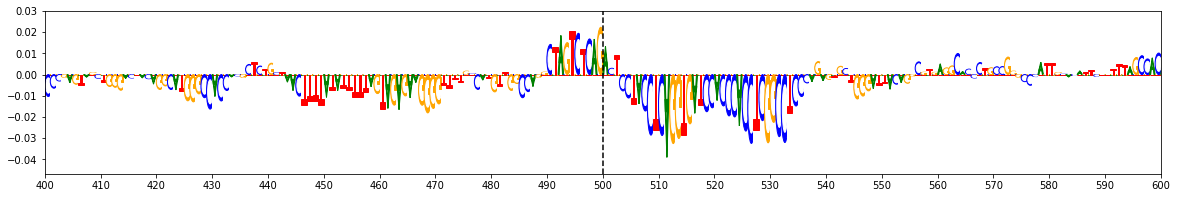

Effect Allele : A   ||   Explain Score : 0.0201   ||   Center / 200bp : 0.0968
Effect Sequence : CTAGTCTCAAACTCCTACCT


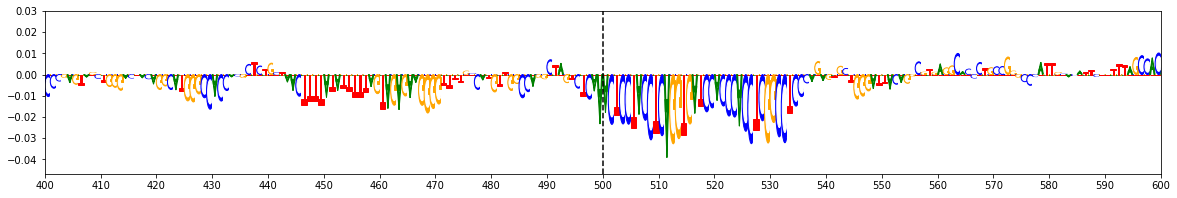

Allele Ratio : 0.1008   ||   Allele Difference : -0.36  ||  ISM Score : -0.5697  ||  deltaSVM Score : -3.2321


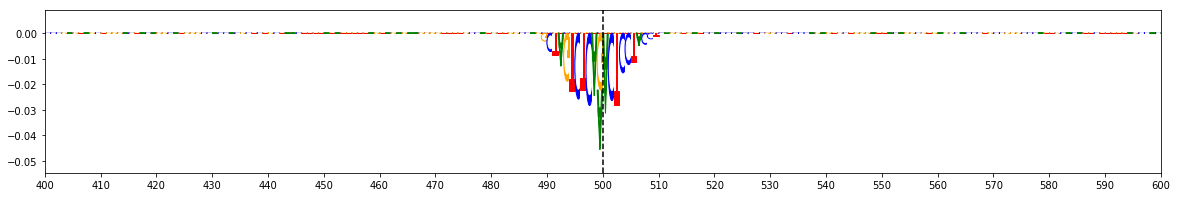


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs755951   ||    chr8 : 27369272 - 27369273   ||    Locus: 311   ||    IDR Peak: False

GWAS:
Alzheimers_Lambert_2013 	  1.99E-07
Alzheimers_Jansen_2018 		  1.31E-11
Alzheimers_Kunkle_2019 		  3.79E-08

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 0.3964   ||   Center / 200bp : 0.829
Noneffect Sequence : TTCACTGGCCTGTAGGGGGA


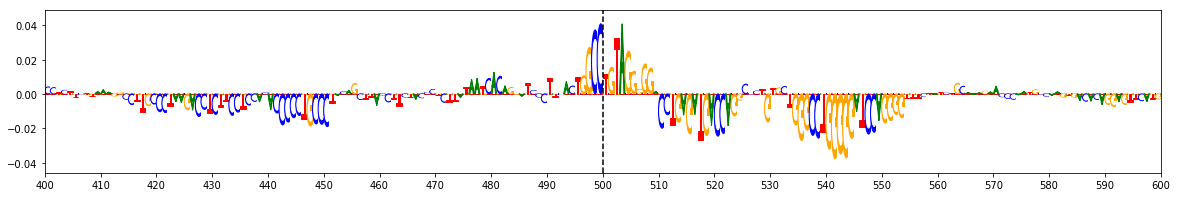

Effect Allele : A   ||   Explain Score : 0.1447   ||   Center / 200bp : 0.6388
Effect Sequence : TTCACTGGCATGTAGGGGGA


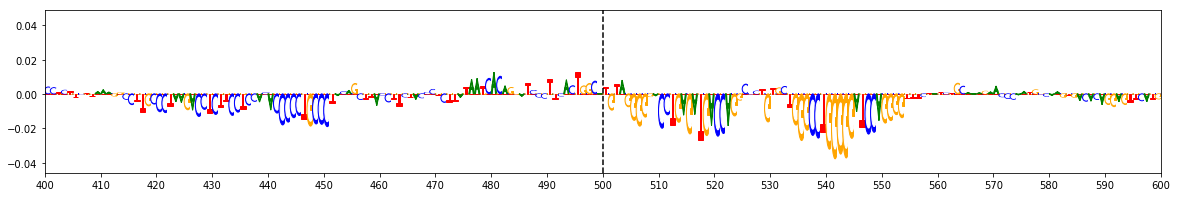

Allele Ratio : 0.365   ||   Allele Difference : -0.3193  ||  ISM Score : -0.4985  ||  deltaSVM Score : -2.8755


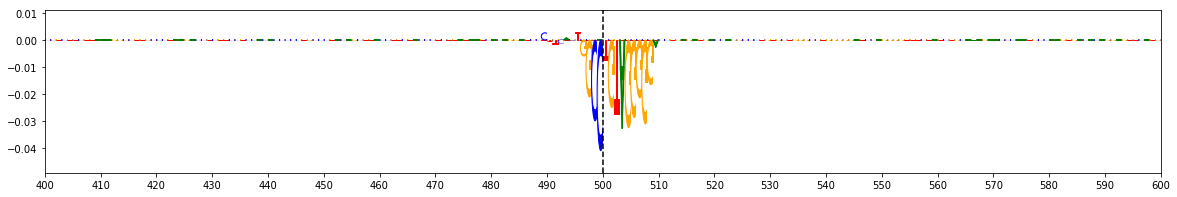


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs344791   ||    chr19 : 45326535 - 45326536   ||    Locus: 221   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  1.22E-04

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.1107   ||   Center / 200bp : 0.2792
Noneffect Sequence : CTCAAGACCGCCTCCACTGT


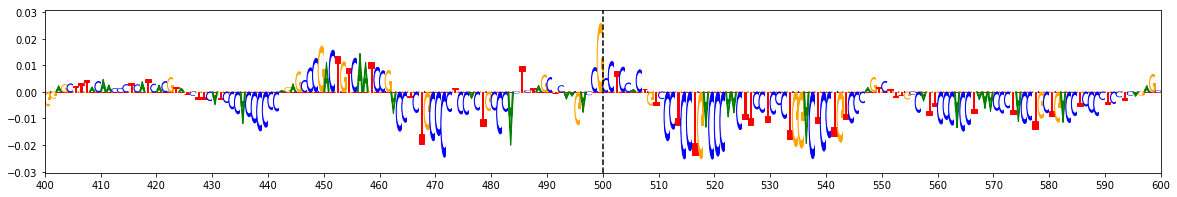

Effect Allele : C   ||   Explain Score : 0.0203   ||   Center / 200bp : 0.0668
Effect Sequence : CTCAAGACCCCCTCCACTGT


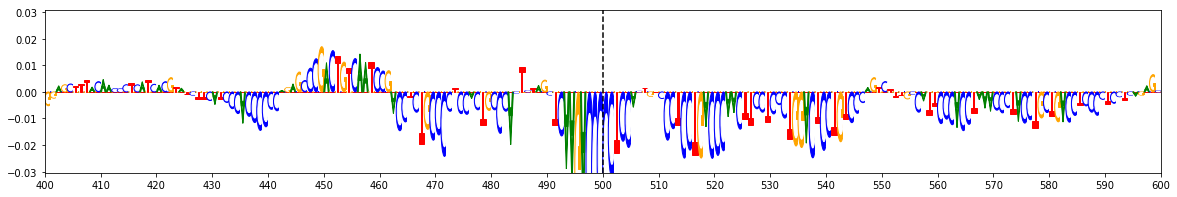

Allele Ratio : 0.1829   ||   Allele Difference : -0.5773  ||  ISM Score : -0.9272  ||  deltaSVM Score : -5.3281


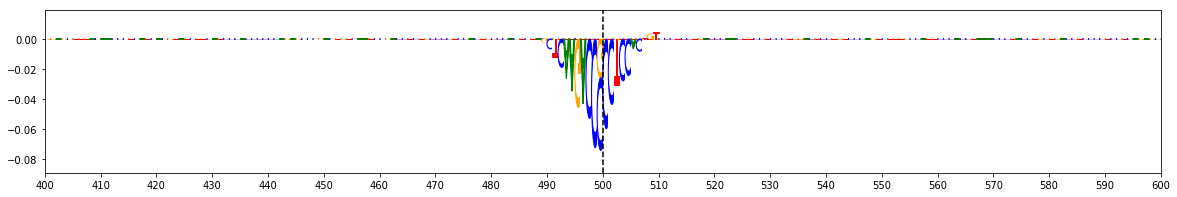


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2619363   ||    chr4 : 89837895 - 89837896   ||    Locus: 276   ||    IDR Peak: True

GWAS:
Parkinsons_Pankratz_2012 	  NAN
23andme_PD_hg38 		  1.43E-08

Coloc:  True

Noneffect Allele : NAN   ||   Explain Score : 1.2288   ||   Center / 200bp : 0.6705
Noneffect Sequence : CCAATCAGCGCCTGCCAGAC


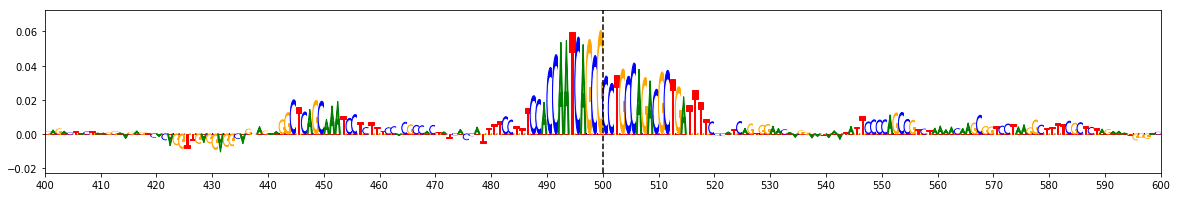

Effect Allele : NAN   ||   Explain Score : 0.7725   ||   Center / 200bp : 0.5594
Effect Sequence : CCAATCAGCCCCTGCCAGAC


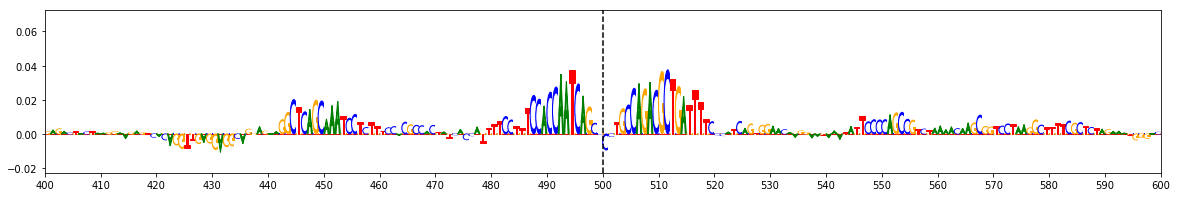

Allele Ratio : 0.6287   ||   Allele Difference : -0.4672  ||  ISM Score : -0.7052  ||  deltaSVM Score : -4.3122


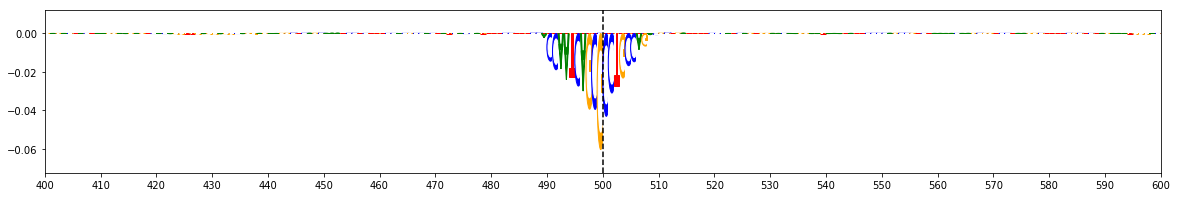


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs1117253   ||    chr17 : 46071930 - 46071931   ||    Locus: 147   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  2.53E-22
Parkinsons_Pankratz_2012 	  4.37E-10

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 0.1068   ||   Center / 200bp : 0.1337
Noneffect Sequence : ATCTTTTGGCGTAATCTTAC


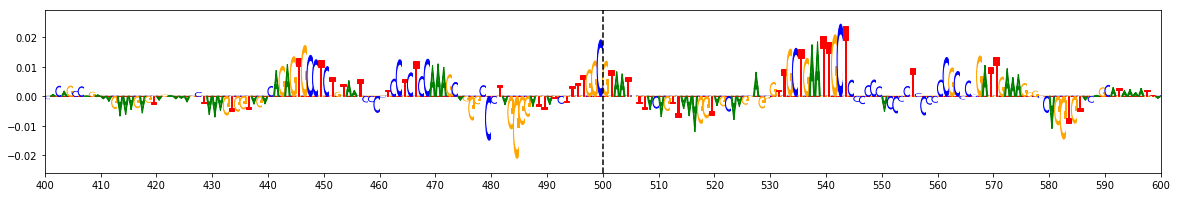

Effect Allele : A   ||   Explain Score : 0.0135   ||   Center / 200bp : 0.0191
Effect Sequence : ATCTTTTGGAGTAATCTTAC


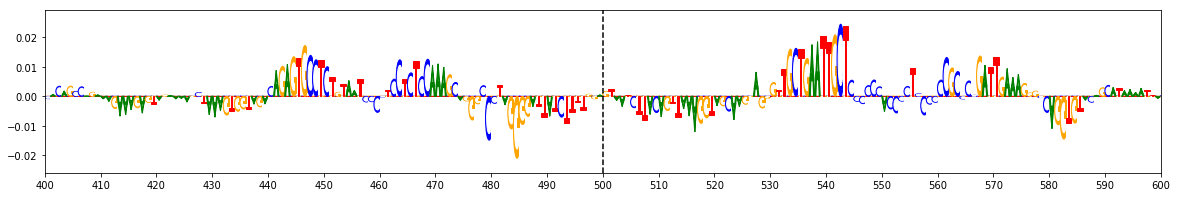

Allele Ratio : 0.126   ||   Allele Difference : -0.1479  ||  ISM Score : -0.2319  ||  deltaSVM Score : -1.3414


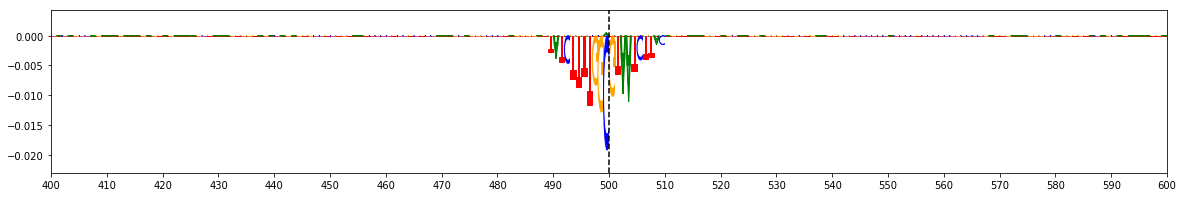


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs12943281   ||    chr17 : 75033998 - 75033999   ||    Locus: 166   ||    IDR Peak: True

GWAS:
Alzheimers_Kunkle_2019 		  1.07E-05
Alzheimers_Lambert_2013 	  1.32E-04

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.1829   ||   Center / 200bp : 0.2065
Noneffect Sequence : TCCTTTTACGGAATTTTTTA


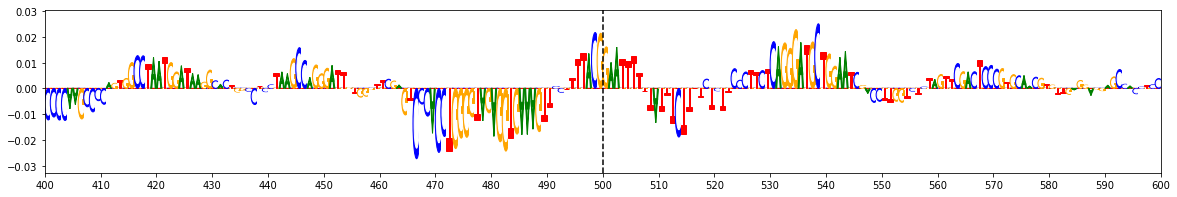

Effect Allele : A   ||   Explain Score : 0.036   ||   Center / 200bp : 0.0487
Effect Sequence : TCCTTTTACAGAATTTTTTA


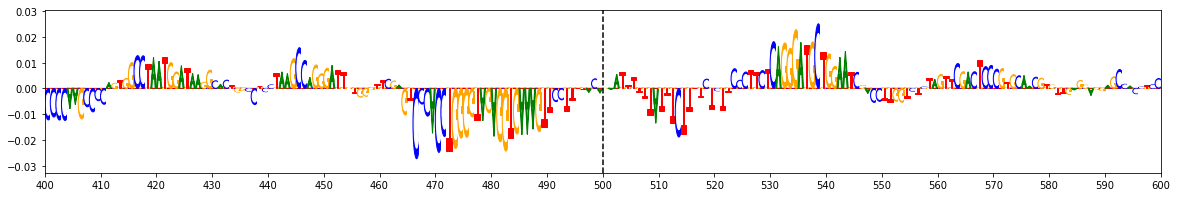

Allele Ratio : 0.1966   ||   Allele Difference : -0.1825  ||  ISM Score : -0.2867  ||  deltaSVM Score : -1.6577


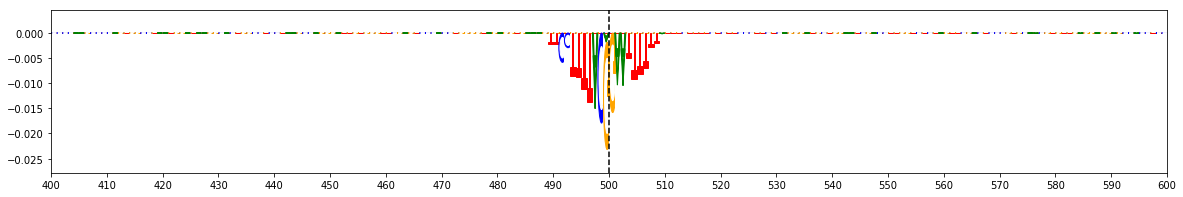


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs1532277   ||    chr8 : 27608663 - 27608664   ||    Locus: 314   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  4.63E-19
Alzheimers_Kunkle_2019 		  3.79E-16
Alzheimers_Lambert_2013 	  3.06E-16

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 0.921   ||   Center / 200bp : 0.7704
Noneffect Sequence : GAACTAGCACGTGATCAGGG


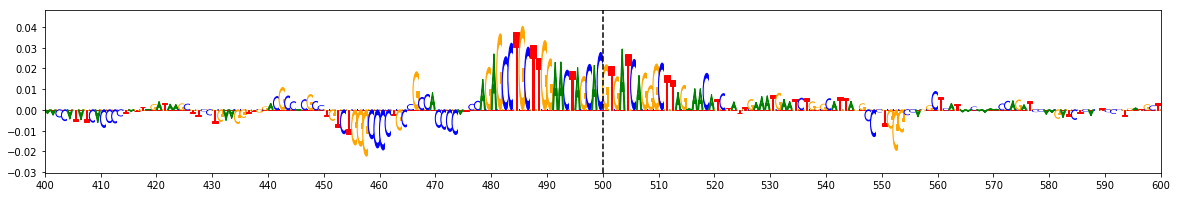

Effect Allele : T   ||   Explain Score : 0.7186   ||   Center / 200bp : 0.7237
Effect Sequence : GAACTAGCATGTGATCAGGG


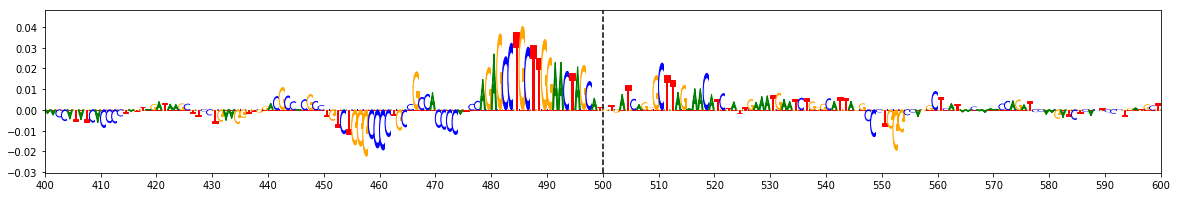

Allele Ratio : 0.7802   ||   Allele Difference : -0.2039  ||  ISM Score : -0.3173  ||  deltaSVM Score : -1.832


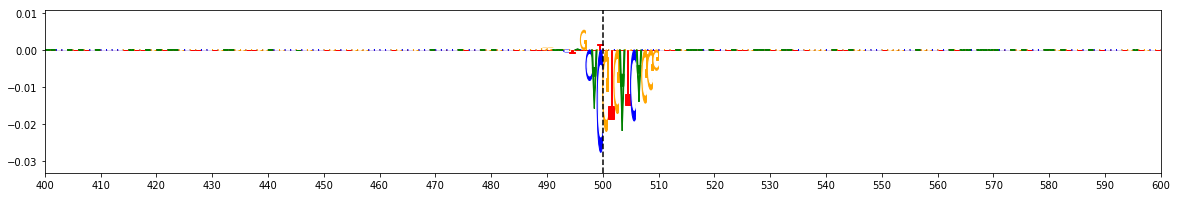


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs77310586   ||    chr17 : 45688014 - 45688015   ||    Locus: 81   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  1.94E-22

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 0.3241   ||   Center / 200bp : 0.5211
Noneffect Sequence : GGGTGAGAGCTTGCACAAGG


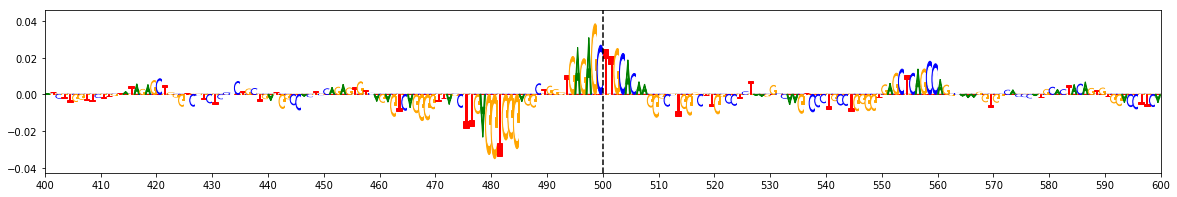

Effect Allele : G   ||   Explain Score : 0.1752   ||   Center / 200bp : 0.3707
Effect Sequence : GGGTGAGAGGTTGCACAAGG


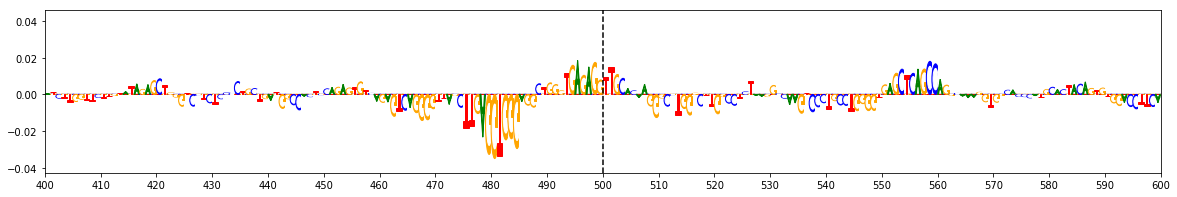

Allele Ratio : 0.5404   ||   Allele Difference : -0.1498  ||  ISM Score : -0.2357  ||  deltaSVM Score : -1.3259


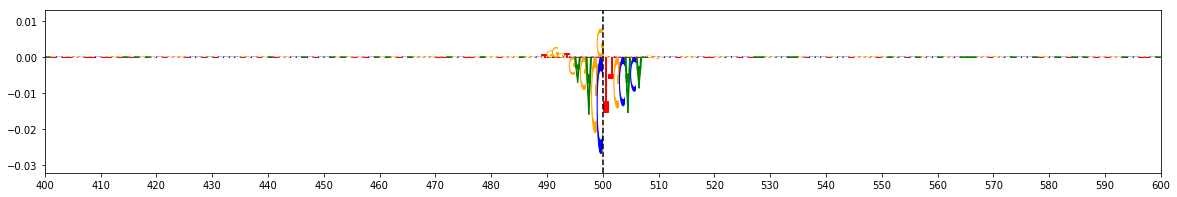


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs1104775   ||    chr2 : 95283238 - 95283239   ||    Locus: 225   ||    IDR Peak: False

GWAS:
Nalls_23andMe 		  1.60E-02

Coloc:  False

Noneffect Allele : A   ||   Explain Score : 1.0563   ||   Center / 200bp : 0.6872
Noneffect Sequence : TCTACTGGCAGGAAGCCATG


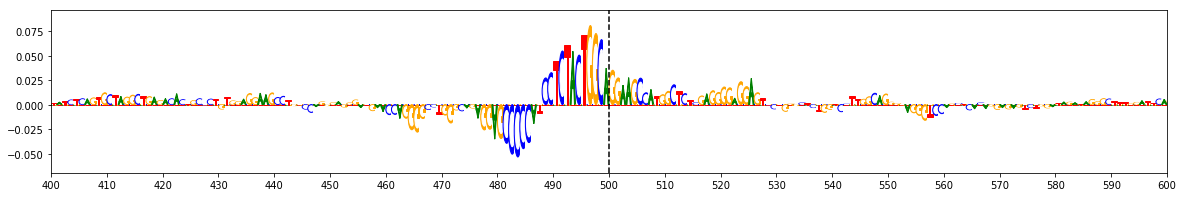

Effect Allele : G   ||   Explain Score : 0.7575   ||   Center / 200bp : 0.6115
Effect Sequence : TCTACTGGCGGGAAGCCATG


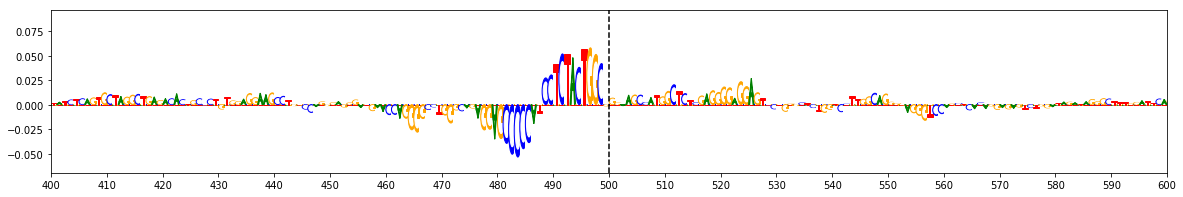

Allele Ratio : 0.7171   ||   Allele Difference : -0.3018  ||  ISM Score : -0.4732  ||  deltaSVM Score : -2.7398


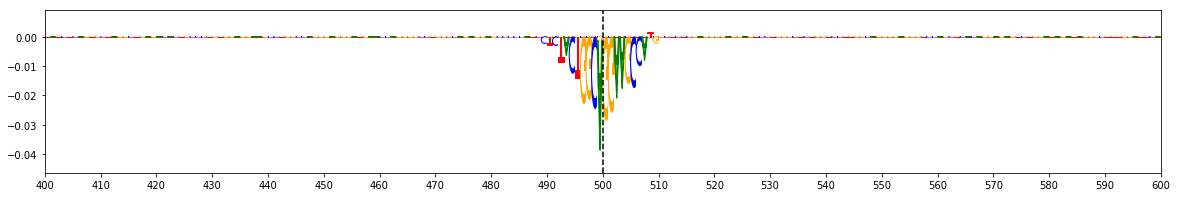


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs7709726   ||    chr5 : 102991758 - 102991759   ||    Locus: 281   ||    IDR Peak: False

GWAS:
Nalls_23andMe 		  9.40E-04

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 0.3635   ||   Center / 200bp : 0.5627
Noneffect Sequence : ATTCATACGCCTCTGTTGCA


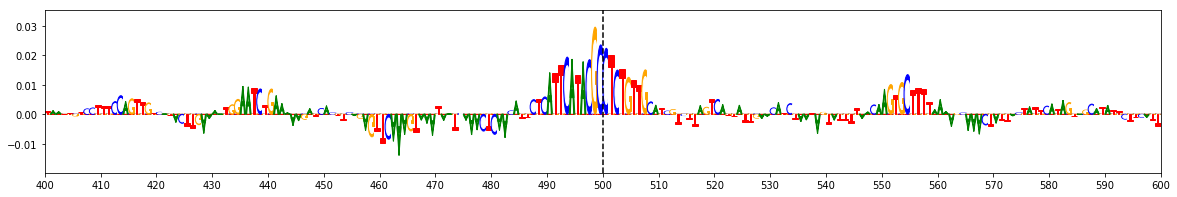

Effect Allele : T   ||   Explain Score : 0.2184   ||   Center / 200bp : 0.4361
Effect Sequence : ATTCATACGTCTCTGTTGCA


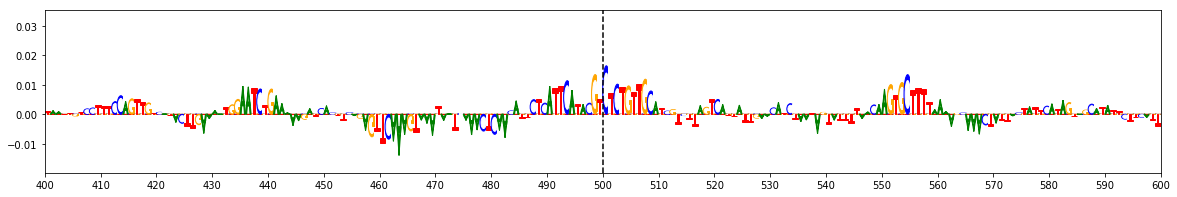

Allele Ratio : 0.6009   ||   Allele Difference : -0.145  ||  ISM Score : -0.2287  ||  deltaSVM Score : -1.3162


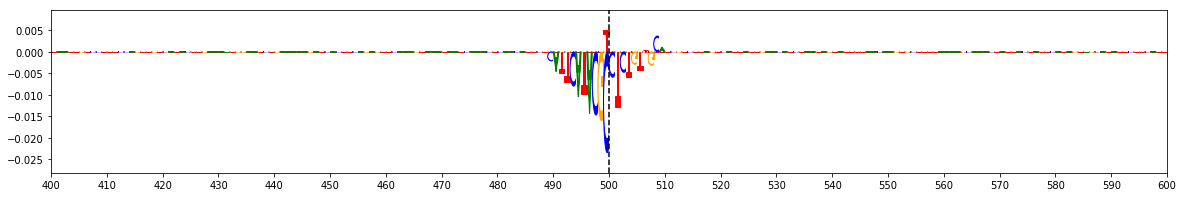


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs17761387   ||    chr17 : 45688083 - 45688084   ||    Locus: 83   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  3.03E-22
Parkinsons_Pankratz_2012 	  7.15E-10

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 0.6019   ||   Center / 200bp : 0.5773
Noneffect Sequence : CAGGCAAAGATGGCACCCAT


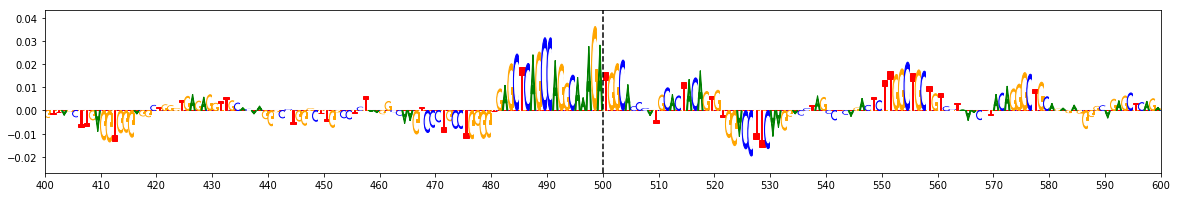

Effect Allele : G   ||   Explain Score : 0.3713   ||   Center / 200bp : 0.4573
Effect Sequence : CAGGCAAAGGTGGCACCCAT


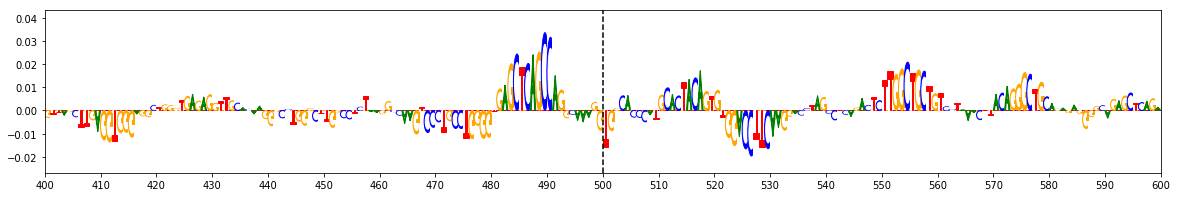

Allele Ratio : 0.6169   ||   Allele Difference : -0.2899  ||  ISM Score : -0.4542  ||  deltaSVM Score : -2.6346


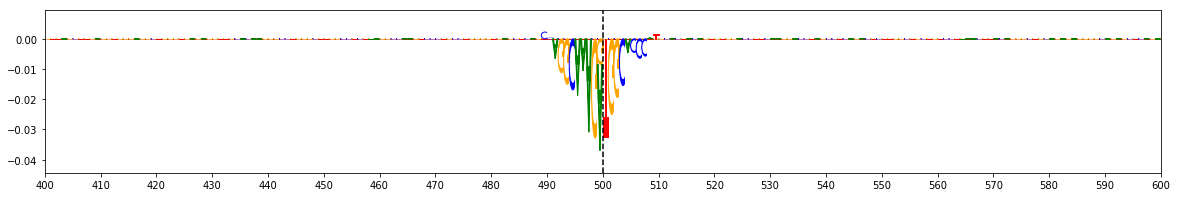


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs7759217   ||    chr6 : 27762683 - 27762684   ||    Locus: 288   ||    IDR Peak: False

GWAS:
Nalls_23andMe 		  2.64E-06

Coloc:  False

Noneffect Allele : A   ||   Explain Score : 0.7451   ||   Center / 200bp : 0.7176
Noneffect Sequence : ACAGCGCAGATAGGGTTGTT


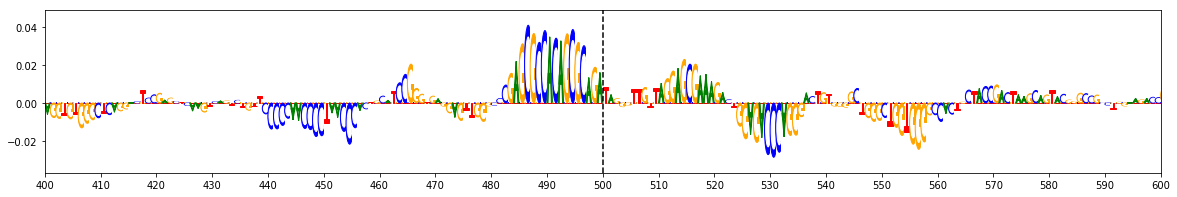

Effect Allele : G   ||   Explain Score : 0.5744   ||   Center / 200bp : 0.6621
Effect Sequence : ACAGCGCAGGTAGGGTTGTT


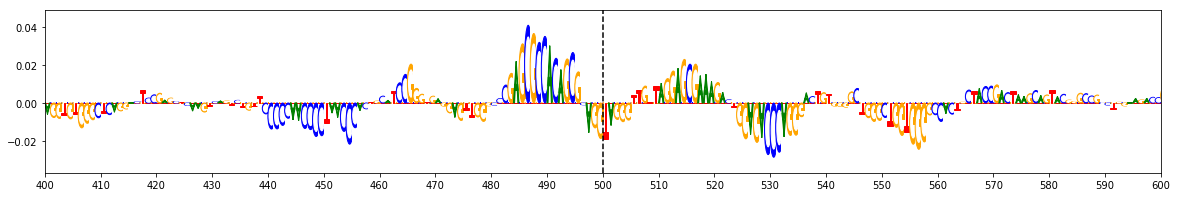

Allele Ratio : 0.771   ||   Allele Difference : -0.2729  ||  ISM Score : -0.4267  ||  deltaSVM Score : -2.464


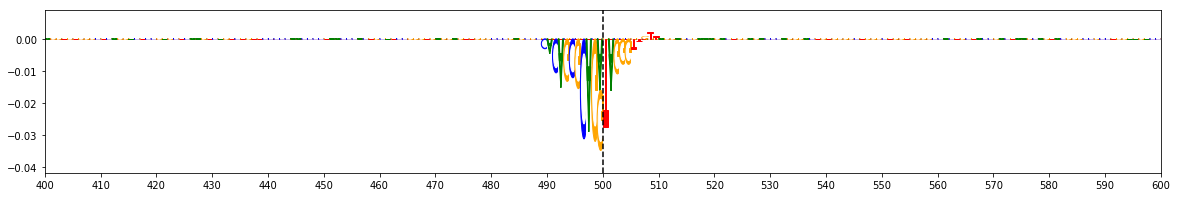


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs12616285   ||    chr2 : 168300396 - 168300397   ||    Locus: 237   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  8.53E-09

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.3901   ||   Center / 200bp : 0.7482
Noneffect Sequence : GTTTTAGGTGGTGTCTTGAT


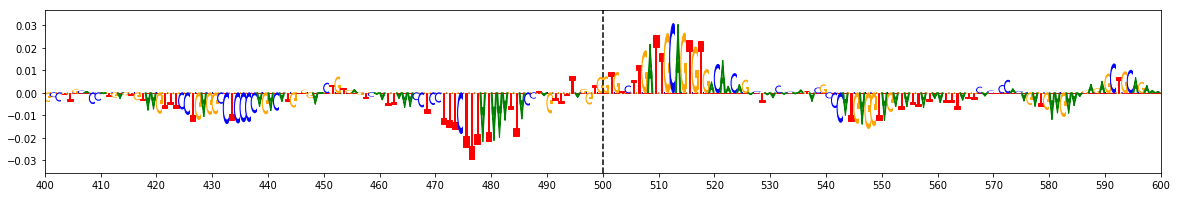

Effect Allele : T   ||   Explain Score : 0.3237   ||   Center / 200bp : 0.7115
Effect Sequence : GTTTTAGGTTGTGTCTTGAT


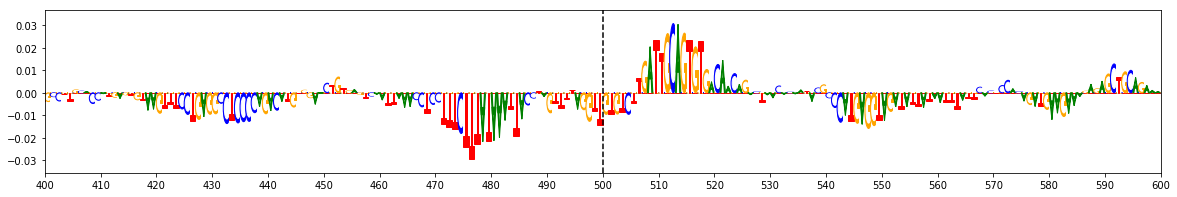

Allele Ratio : 0.8297   ||   Allele Difference : -0.1666  ||  ISM Score : -0.2609  ||  deltaSVM Score : -1.4905


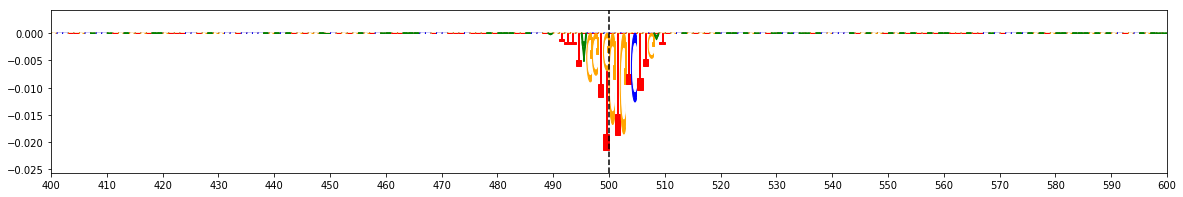


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs17167630   ||    chr5 : 134587210 - 134587211   ||    Locus: 286   ||    IDR Peak: False

GWAS:
Nalls_23andMe 		  2.90E-02

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 0.8053   ||   Center / 200bp : 0.7059
Noneffect Sequence : AGAATAAACCATTGGCTGAG


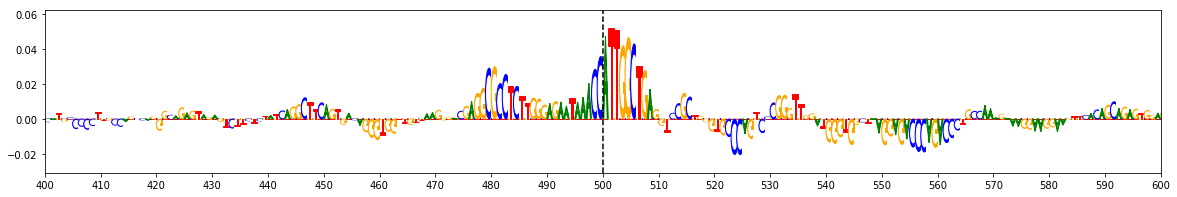

Effect Allele : T   ||   Explain Score : 0.6393   ||   Center / 200bp : 0.6558
Effect Sequence : AGAATAAACTATTGGCTGAG


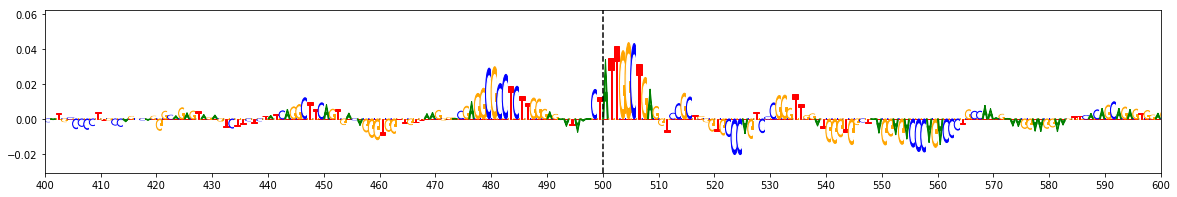

Allele Ratio : 0.7938   ||   Allele Difference : -0.1832  ||  ISM Score : -0.2884  ||  deltaSVM Score : -1.6802


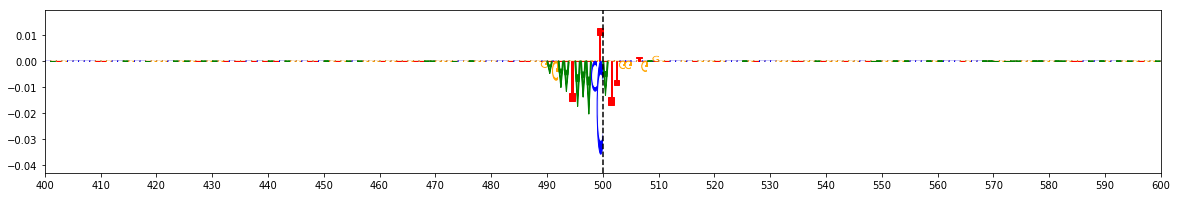


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs79589869   ||    chr17 : 45852871 - 45852872   ||    Locus: 105   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  1.11E-22

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 2.6248   ||   Center / 200bp : 0.8546
Noneffect Sequence : TTGAATGCTACTGTGCTGCC


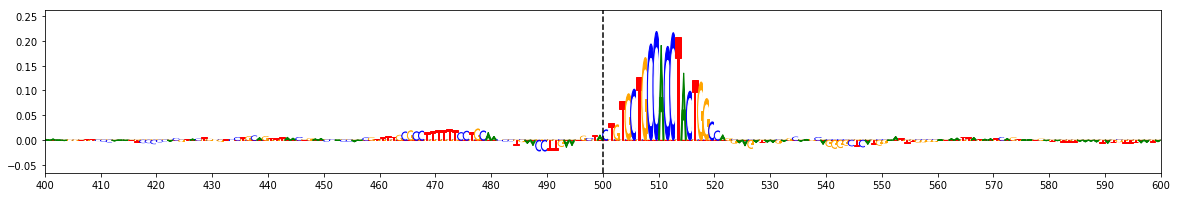

Effect Allele : C   ||   Explain Score : 2.5353   ||   Center / 200bp : 0.8502
Effect Sequence : TTGAATGCTCCTGTGCTGCC


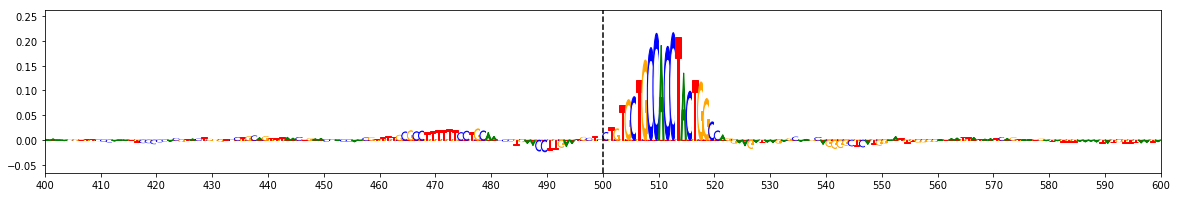

Allele Ratio : 0.9659   ||   Allele Difference : -0.0867  ||  ISM Score : -0.136  ||  deltaSVM Score : -0.7879


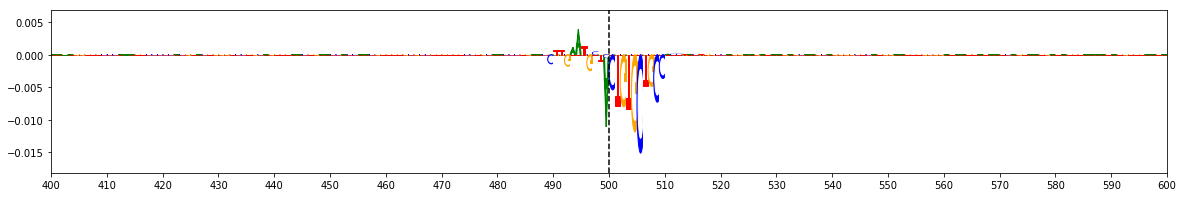


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs79724577   ||    chr17 : 45386126 - 45386127   ||    Locus: 74   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  5.92E-20

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 0.8244   ||   Center / 200bp : 0.5646
Noneffect Sequence : AAGGTTGCCAGGGATTAGGG


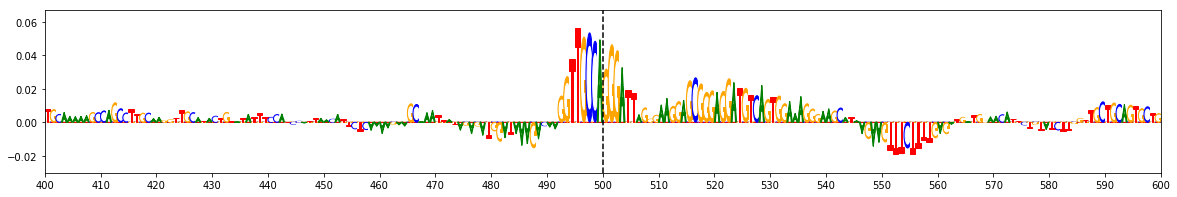

Effect Allele : C   ||   Explain Score : 0.537   ||   Center / 200bp : 0.4577
Effect Sequence : AAGGTTGCCCGGGATTAGGG


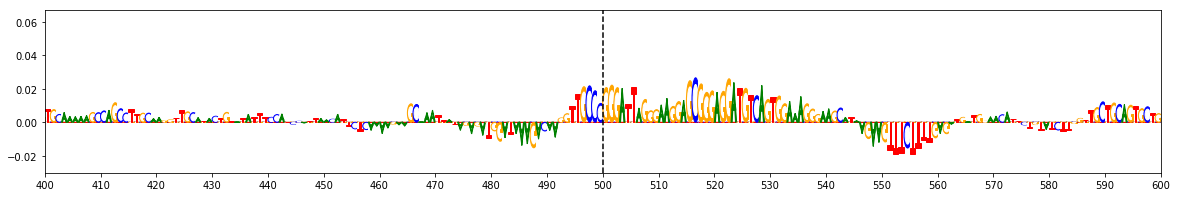

Allele Ratio : 0.6513   ||   Allele Difference : -0.2974  ||  ISM Score : -0.4685  ||  deltaSVM Score : -2.6945


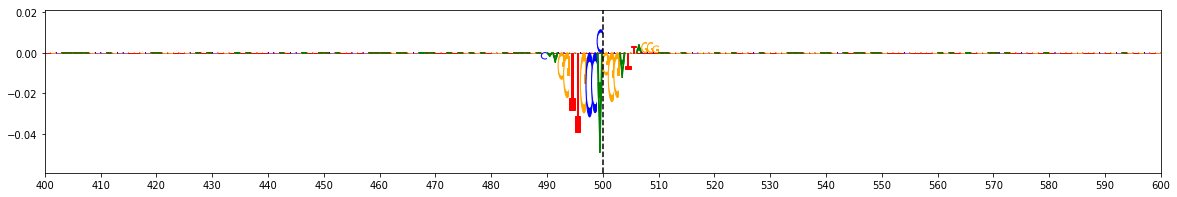


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs74509629   ||    chr17 : 45908230 - 45908231   ||    Locus: 128   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  3.94E-22

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 0.8039   ||   Center / 200bp : 0.5686
Noneffect Sequence : TTTTTCTTCCGGCTCACATC


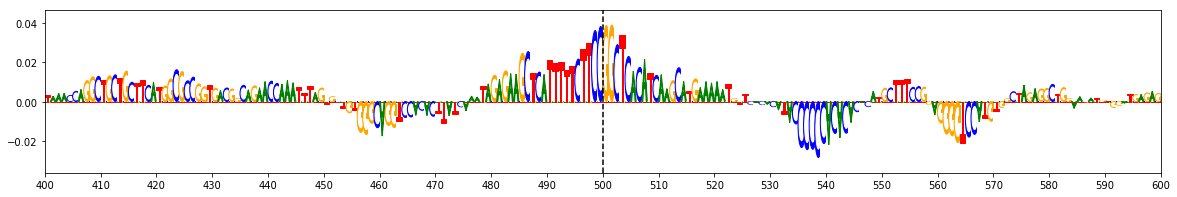

Effect Allele : T   ||   Explain Score : 0.5295   ||   Center / 200bp : 0.4646
Effect Sequence : TTTTTCTTCTGGCTCACATC


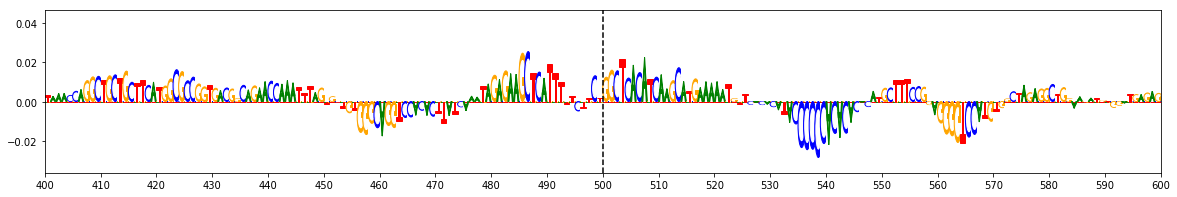

Allele Ratio : 0.6587   ||   Allele Difference : -0.2836  ||  ISM Score : -0.4429  ||  deltaSVM Score : -2.5659


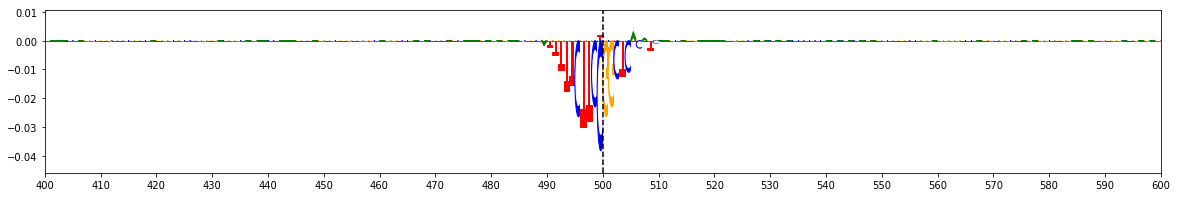


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2290850   ||    chr11 : 47786221 - 47786222   ||    Locus: 14   ||    IDR Peak: False

GWAS:
Alzheimers_Kunkle_2019 		  2.66E-08

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 0.1141   ||   Center / 200bp : 0.2163
Noneffect Sequence : AACAGTAAGCCTTTGAGGAG


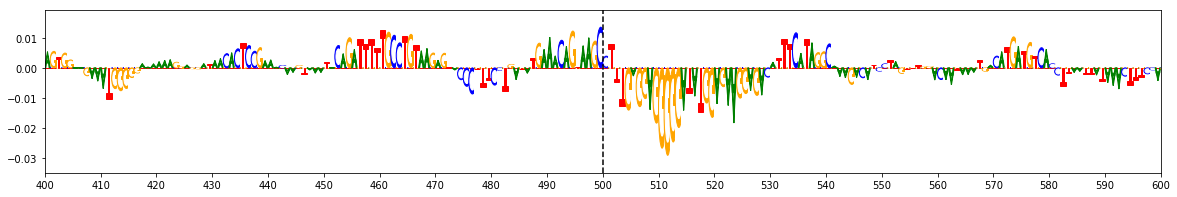

Effect Allele : T   ||   Explain Score : 0.0288   ||   Center / 200bp : 0.0652
Effect Sequence : AACAGTAAGTCTTTGAGGAG


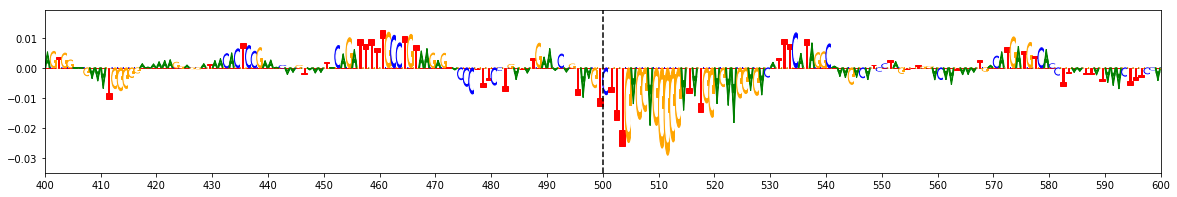

Allele Ratio : 0.2522   ||   Allele Difference : -0.2068  ||  ISM Score : -0.3237  ||  deltaSVM Score : -1.8652


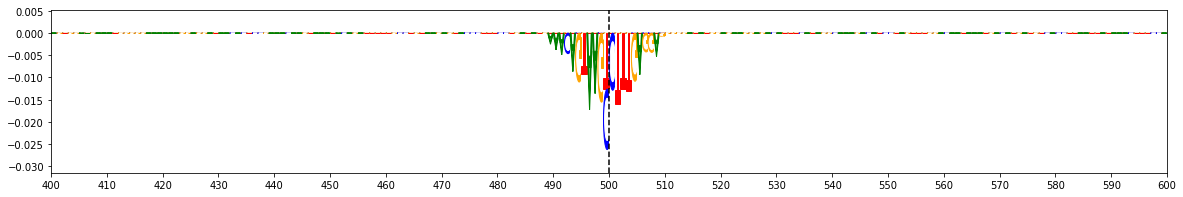


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs896434   ||    chr10 : 15515276 - 15515277   ||    Locus: 5   ||    IDR Peak: False

GWAS:
Chang_23andMe_Parkinsons 	  4.87E-04
Nalls_23andMe 		  4.87E-04

Coloc:  False

Noneffect Allele : G   ||   Explain Score : 0.7029   ||   Center / 200bp : 0.6733
Noneffect Sequence : CAGTGCTCAGCCGTAGTCAG


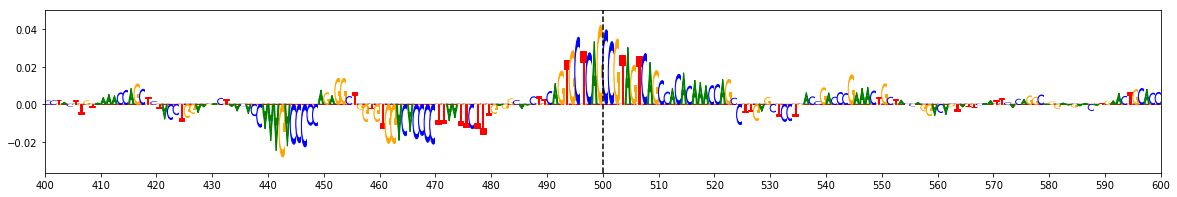

Effect Allele : T   ||   Explain Score : 0.5599   ||   Center / 200bp : 0.6215
Effect Sequence : CAGTGCTCATCCGTAGTCAG


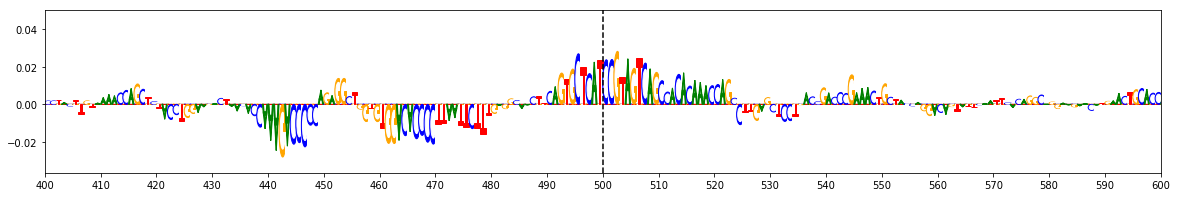

Allele Ratio : 0.7965   ||   Allele Difference : -0.143  ||  ISM Score : -0.2225  ||  deltaSVM Score : -1.288


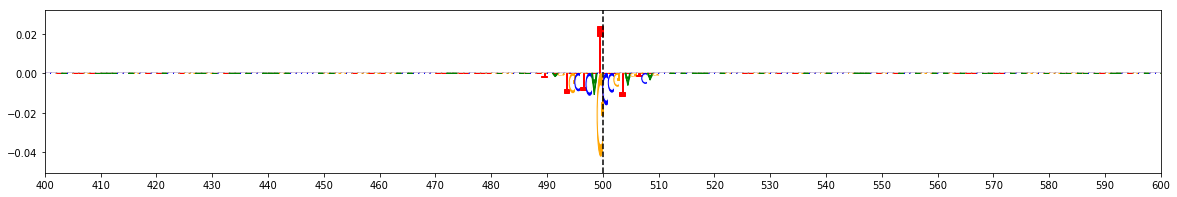


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs6881225   ||    chr5 : 102971887 - 102971888   ||    Locus: 280   ||    IDR Peak: False

GWAS:
Nalls_23andMe 		  1.13E-03

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 2.1414   ||   Center / 200bp : 0.7852
Noneffect Sequence : TGTAAGAGACAGCCATCTAG


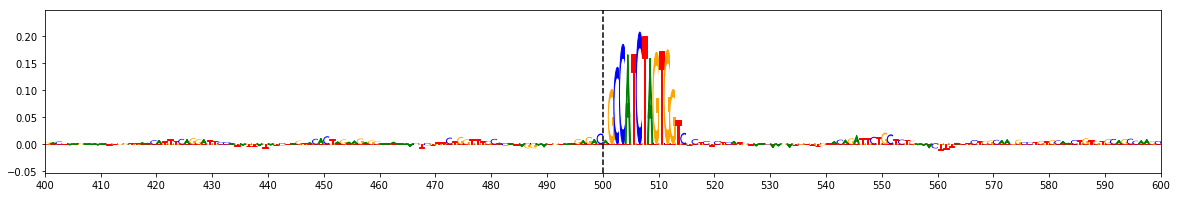

Effect Allele : T   ||   Explain Score : 1.9924   ||   Center / 200bp : 0.773
Effect Sequence : TGTAAGAGATAGCCATCTAG


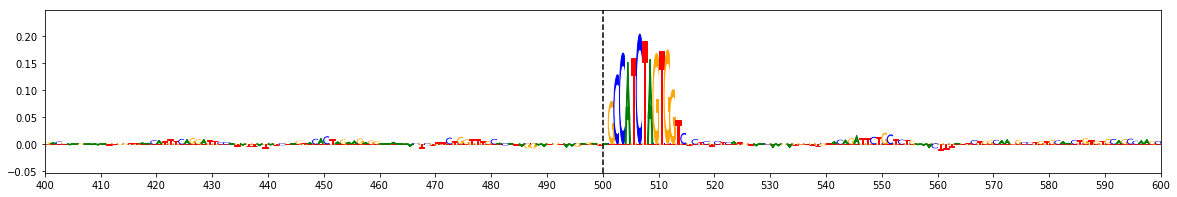

Allele Ratio : 0.9304   ||   Allele Difference : -0.1667  ||  ISM Score : -0.2629  ||  deltaSVM Score : -1.4696


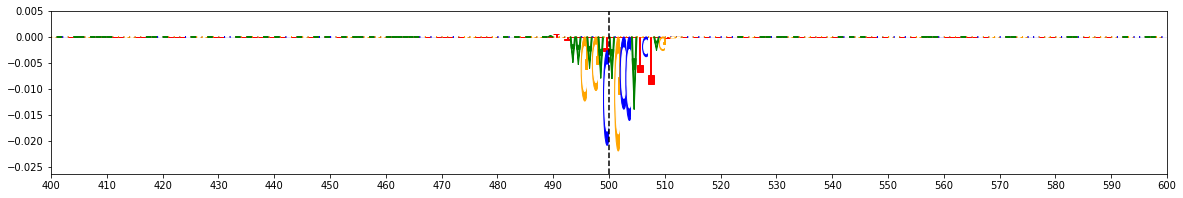


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [6]:
for idx in neg_snps.index[:20]:
    #for idx in [60]:
    print('RSID:', neg_snps.at[idx, 'rsid'],
          '  ||   ', neg_snps.at[idx, 'chr'], ':', neg_snps.at[idx, 'start'], '-', neg_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', idx, '  ||   ', 'IDR Peak:', neg_snps.at[idx, 'idr_peak'])
    
    print()
    
    print('GWAS:')
    
    for i in neg_snps.at[idx, 'all_gwas']:
        entry = i.split(':')
        if 'Lambert' in entry[0] or 'Pankratz' in entry[0] or 'Chang' in entry[0]:
            print(entry[0], '\t', entry[1])
        else:
            print(entry[0], '\t\t', entry[1])
    
    print()
    
    print("Coloc: ", neg_snps.at[idx, 'coloc'])
    
    print()
    
    print('Noneffect Allele :', neg_snps.at[idx, 'noneffect'], '  ||   Explain Score :', round(neg_snps.at[idx, 'noneffect_center'], 4), '  ||   Center / 200bp :', round(neg_snps.at[idx, 'noneffect_ratio'], 4))
    print('Noneffect Sequence :', noneffect_seqs[idx][490:510])
    
    ylim = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, xlim=(400,600))

    print('Effect Allele :', neg_snps.at[idx, 'effect'], '  ||   Explain Score :', round(neg_snps.at[idx, 'effect_center'], 4), '  ||   Center / 200bp :', round(neg_snps.at[idx, 'effect_ratio'], 4))
    print('Effect Sequence :', effect_seqs[idx][490:510])
    
    a = plot_weights(merged_effect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('Allele Ratio :', round(neg_snps.at[idx, 'allele_ratio'], 4), '  ||   Allele Difference :', round(neg_snps.at[idx, 'allele_diff'], 4),
          ' ||  ISM Score :', round(neg_snps.at[idx, 'ism_score'], 4), ' ||  deltaSVM Score :', round(neg_snps.at[idx, 'delta_score'], 4))
    
    a = plot_weights(merged_effect_scores[idx] - merged_noneffect_scores[idx], subticks_frequency=10, xlim=(400,600))
    
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()

## Find Non-Effect Alleles that Improve Accessibility <a name='noneffect_table' />

In [7]:
pos_snps = snps.loc[snps['allele_ratio'] > 1]
pos_snps.sort_values(by=['effect_rank'], ascending=False, inplace=True)
display(pos_snps)

chr      start        end         rsid effect noneffect         ref  \
157  chr17   46238709   46238710   rs55653937      T         G           G   
92   chr17   45756554   45756555   rs34195569      G         A           G   
65   chr16   52603450   52603451    rs3104786      G         A           A   
66   chr16   52603522   52603523    rs4578643      T         G           G   
26   chr12   33992725   33992726  rs139357253      C         A           C   
274   chr4   89765967   89765968    rs3775427      G         A           G   
207  chr19   45039212   45039213   rs34034621      T         C           C   
123  chr17   45897109   45897110   rs80346216      T         G           G   
156  chr17   46238436   46238437    rs2696673      C         A           A   
279   chr5  102910380  102910381   rs35100629      G         C           C   
91   chr17   45756457   45756458   rs36047693      G         C           G   
162  chr17   46771150   46771151     rs199523      C         A           C   
155  chr17   46213392   46213393    rs2668662      T         C           T   
47   chr16   30010080   30010081    rs1140239    NAN       NAN           C   
24   chr11   86069405   86069406    rs3016327      T         C           T   
97   chr17   45775366   45775367  rs113871181      G         A           G   
94   chr17   45756707   45756708   rs34211253      G         C           C   
295   chr7   23205949   23205950     rs858295      G         A           A   
282   chr5  102992164  102992165    rs3776863      G         C           G   
35   chr14   54886144   54886145   rs10136545      T         C           C   
258   chr4     860282     860283  rs534567593    NAN       NAN        TGAC   
19   chr11   85978391   85978392     rs618629      T         C           T   
62   chr16   31106091   31106092    rs2032915      T         C           C   
222   chr2   95076932   95076933    rs3105101      C         A           C   
179  chr19   44723890   44723891  rs150820726      T         A           A   
32   chr12   40937922   40937923   rs76625216      T         A           A   
238   chr2  233152670  233152671  rs145770967      A         C           C   
98   chr17   45775375   45775376  rs111370985      T         C           T   
313   chr8   27608639   27608640    rs1532276      T         C           T   
3     chr1  226737182  226737183  rs147889095      I         D  ACTGCCGCTG   
..     ...        ...        ...          ...    ...       ...         ...   
79   chr17   45584384   45584385    rs2693359      T         A           T   
126  chr17   45906434   45906435   rs62056806      G         A           A   
25   chr12   32657824   32657825  rs181609621      C         A           A   
205  chr19   45001268   45001269  rs117612135      T         C           C   
17   chr11   65834088   65834089   rs17854357      C         G           G   
318   chr9   17579691   17579692   rs13294100      T         G           T   
263   chr4     973656     973657   rs13137144      G         A           G   
304   chr8   22604860   22604861    rs3735901      T         C           T   
305   chr8   22623005   22623006   rs11780207      G         A           G   
251   chr3   52307781   52307782  rs149776414      G         A           G   
23   chr11   86068267   86068268    rs2458500      A         G           A   
102  chr17   45818861   45818862   rs12150390      T         C           T   
125  chr17   45897182   45897183   rs62056783      G         C           G   
182  chr19   44758447   44758448   rs34967149      T         C           C   
183  chr19   44784591   44784592    rs2927448      T         G           G   
21   chr11   86004809   86004810     rs528109      C         T           C   
37   chr14   67515536   67515537    rs7154258      T         G           G   
121  chr17   45896131   45896132    rs4792891      T         G           T   
193  chr19   44915228   44915229   rs12691088      A         G           G   
34   chr12  122836031  122836

## Visualize Top Non-Effect Alleles <a name='noneffect_viz' />

RSID: rs55653937   ||    chr17 : 46238709 - 46238710   ||    Locus: 157   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  9.51E-22

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.0456   ||  Center / 200bp: 0.1891
Effect Sequence: CCTGGCCAATATGGTGAAAC


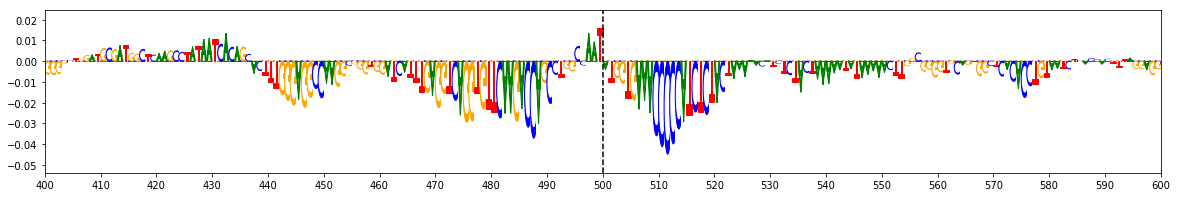

Noneffect Allele: G   ||  Explain Score: 0.0   ||  Center / 200bp: 0.0
Noneffect Sequence: CCTGGCCAAGATGGTGAAAC


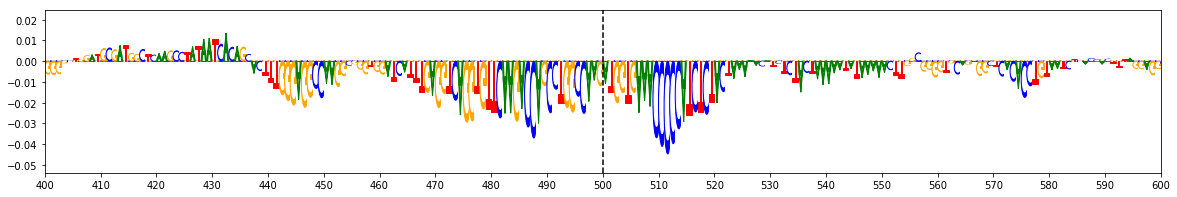

Allele Ratio : 4563.141   ||   Allele Difference : 0.215  ||  ISM Score : 0.3541  ||  deltaSVM Score : 2.1127


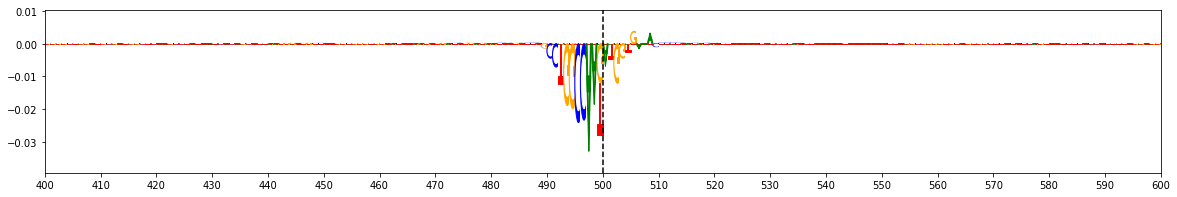


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs34195569   ||    chr17 : 45756554 - 45756555   ||    Locus: 92   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  3.43E-22

Coloc:  True

Effect Allele: G   ||  Explain Score: 0.508   ||  Center / 200bp: 0.4824
Effect Sequence: TCTCATTCAGCTGGCAATCC


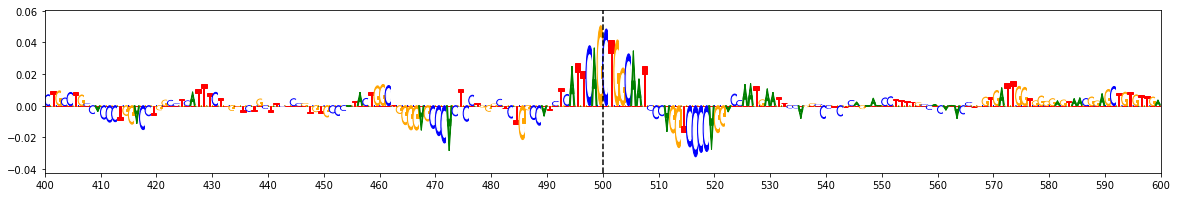

Noneffect Allele: A   ||  Explain Score: 0.1705   ||  Center / 200bp: 0.2382
Noneffect Sequence: TCTCATTCAACTGGCAATCC


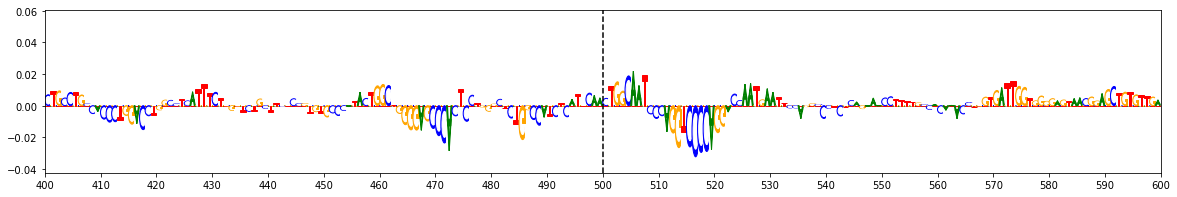

Allele Ratio : 2.9785   ||   Allele Difference : 0.3585  ||  ISM Score : 0.5601  ||  deltaSVM Score : 3.2345


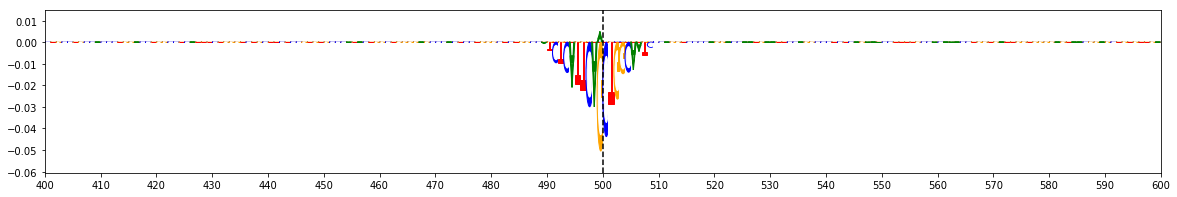


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs3104786   ||    chr16 : 52603450 - 52603451   ||    Locus: 65   ||    IDR Peak: False

GWAS:
Nalls_23andMe 		  9.56E-03

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.6442   ||  Center / 200bp: 0.6959
Effect Sequence: TGCAGTGGCGCAGTCTTGGC


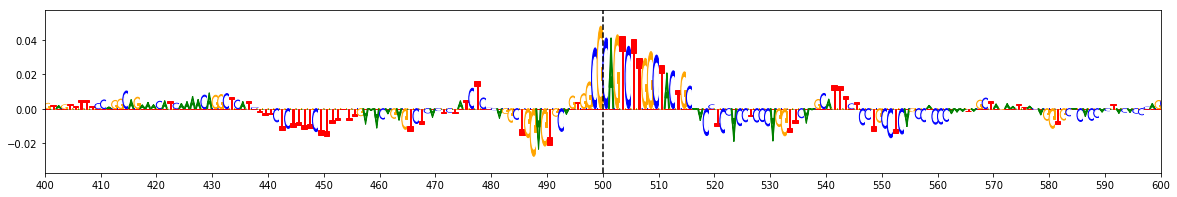

Noneffect Allele: A   ||  Explain Score: 0.3305   ||  Center / 200bp: 0.54
Noneffect Sequence: TGCAGTGGCACAGTCTTGGC


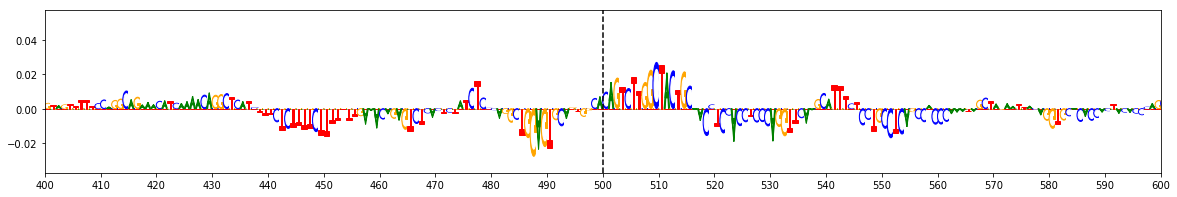

Allele Ratio : 1.949   ||   Allele Difference : 0.3243  ||  ISM Score : 0.5074  ||  deltaSVM Score : 2.9138


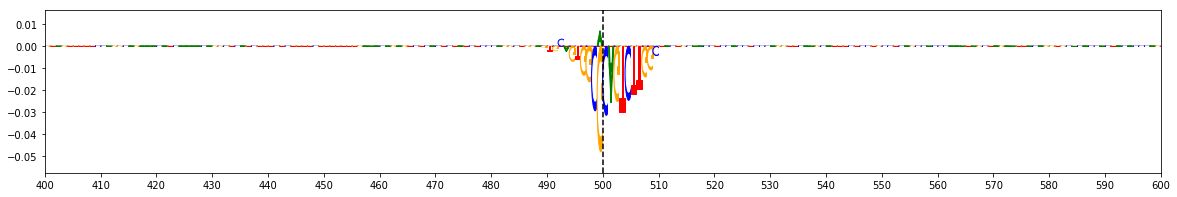


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs4578643   ||    chr16 : 52603522 - 52603523   ||    Locus: 66   ||    IDR Peak: False

GWAS:
Nalls_23andMe 		  1.06E-02

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.2536   ||  Center / 200bp: 0.4175
Effect Sequence: AAATAGCTATAATTACAGGT


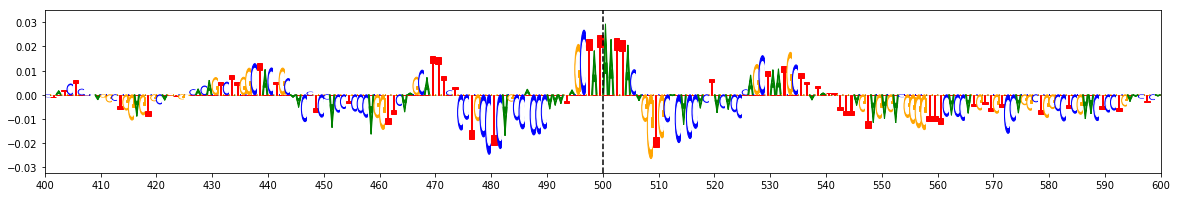

Noneffect Allele: G   ||  Explain Score: 0.0811   ||  Center / 200bp: 0.1864
Noneffect Sequence: AAATAGCTAGAATTACAGGT


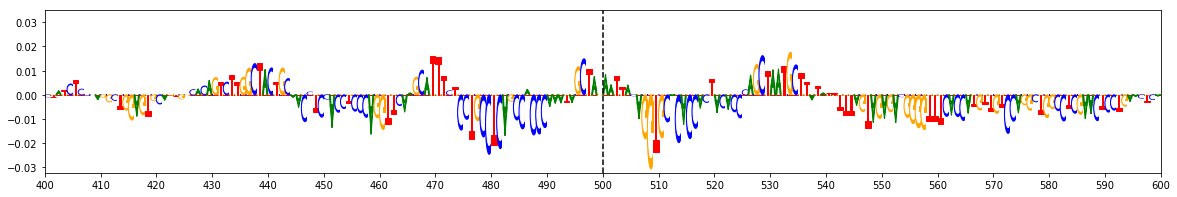

Allele Ratio : 3.1262   ||   Allele Difference : 0.1948  ||  ISM Score : 0.3041  ||  deltaSVM Score : 1.7318


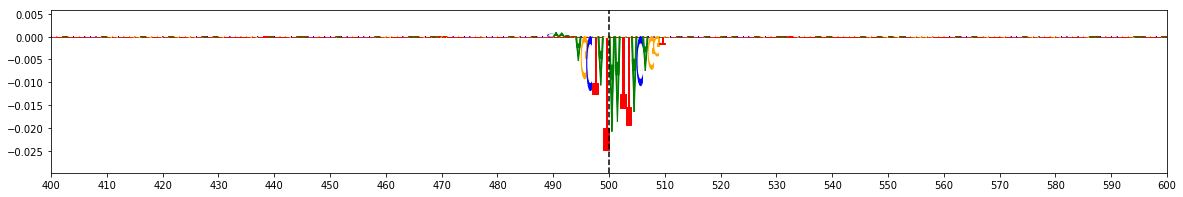


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs139357253   ||    chr12 : 33992725 - 33992726   ||    Locus: 26   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  1.64E-08

Coloc:  False

Effect Allele: C   ||  Explain Score: 0.2689   ||  Center / 200bp: 0.4747
Effect Sequence: CTACAGATTCTAATTCATTA


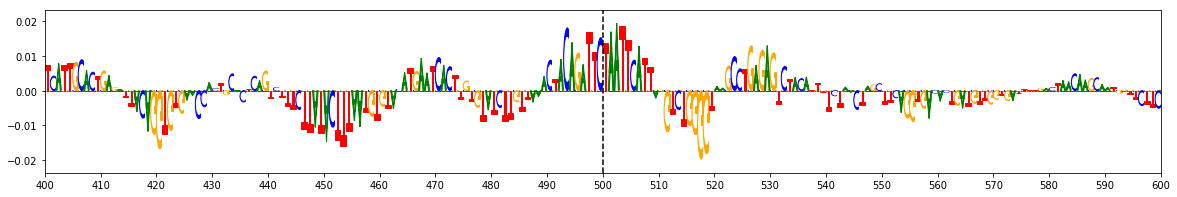

Noneffect Allele: A   ||  Explain Score: 0.107   ||  Center / 200bp: 0.2641
Noneffect Sequence: CTACAGATTATAATTCATTA


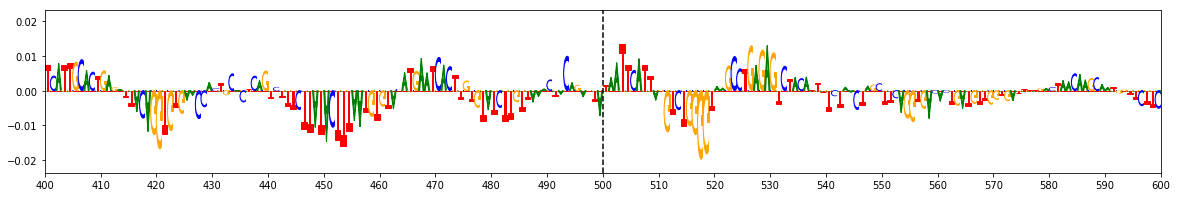

Allele Ratio : 2.513   ||   Allele Difference : 0.1777  ||  ISM Score : 0.2793  ||  deltaSVM Score : 1.6208


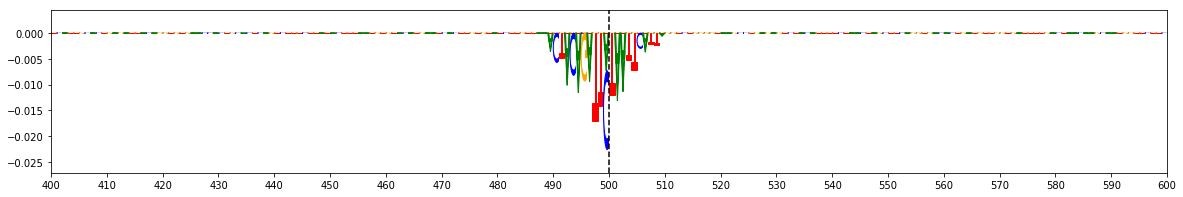


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs3775427   ||    chr4 : 89765967 - 89765968   ||    Locus: 274   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  3.74E-12

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.4176   ||  Center / 200bp: 0.5972
Effect Sequence: AAAAATTATGTAATGCAATG


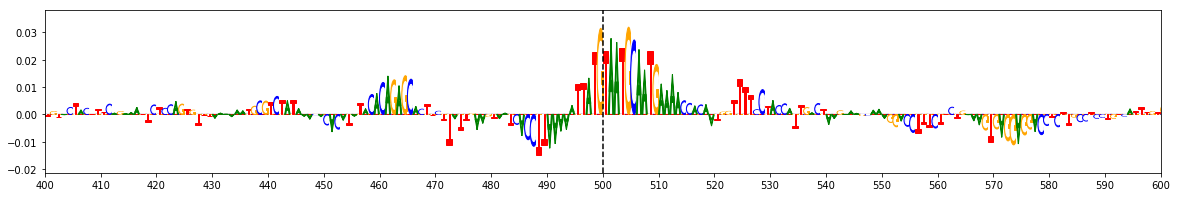

Noneffect Allele: A   ||  Explain Score: 0.2152   ||  Center / 200bp: 0.4339
Noneffect Sequence: AAAAATTATATAATGCAATG


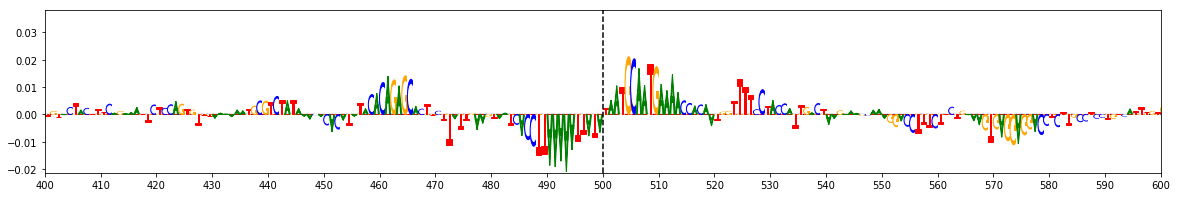

Allele Ratio : 1.9406   ||   Allele Difference : 0.2984  ||  ISM Score : 0.4682  ||  deltaSVM Score : 2.7175


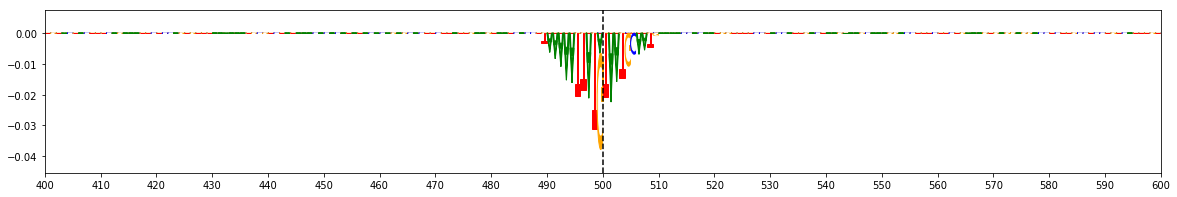


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs34034621   ||    chr19 : 45039212 - 45039213   ||    Locus: 207   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  4.19E-08

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.4608   ||  Center / 200bp: 0.5022
Effect Sequence: CTGCTGCGTTCCGGCCCCGA


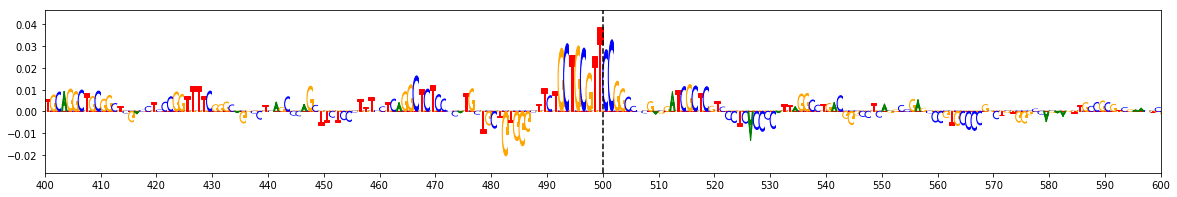

Noneffect Allele: C   ||  Explain Score: 0.201   ||  Center / 200bp: 0.3059
Noneffect Sequence: CTGCTGCGTCCCGGCCCCGA


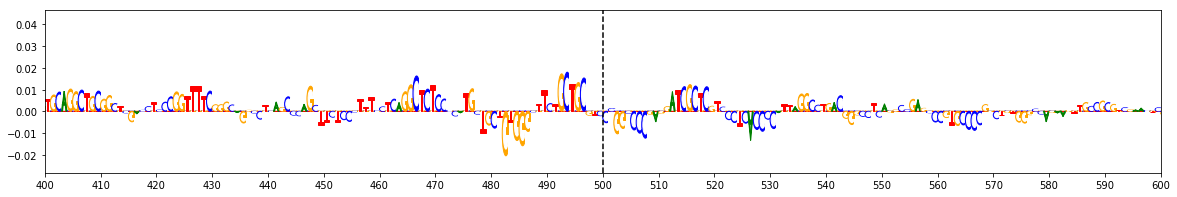

Allele Ratio : 2.2925   ||   Allele Difference : 0.325  ||  ISM Score : 0.5145  ||  deltaSVM Score : 2.9756


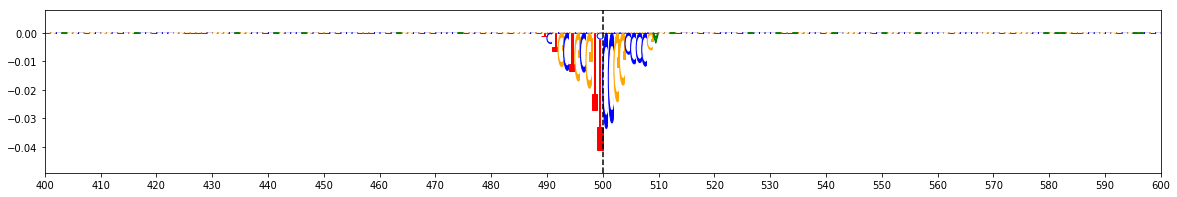


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs80346216   ||    chr17 : 45897109 - 45897110   ||    Locus: 123   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  3.94E-22

Coloc:  True

Effect Allele: T   ||  Explain Score: 1.0997   ||  Center / 200bp: 0.6042
Effect Sequence: GCCCGCCGCTAGGGGTTGCA


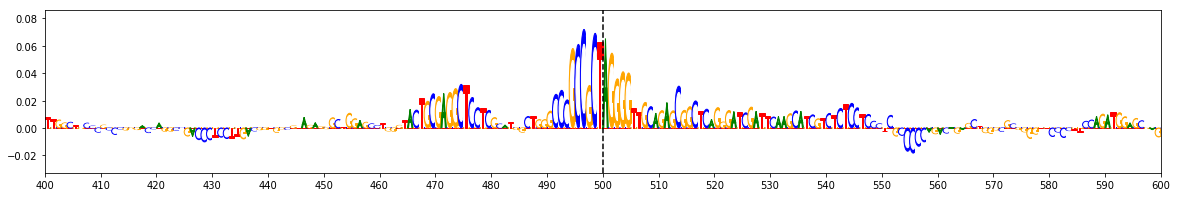

Noneffect Allele: G   ||  Explain Score: 0.6722   ||  Center / 200bp: 0.4829
Noneffect Sequence: GCCCGCCGCGAGGGGTTGCA


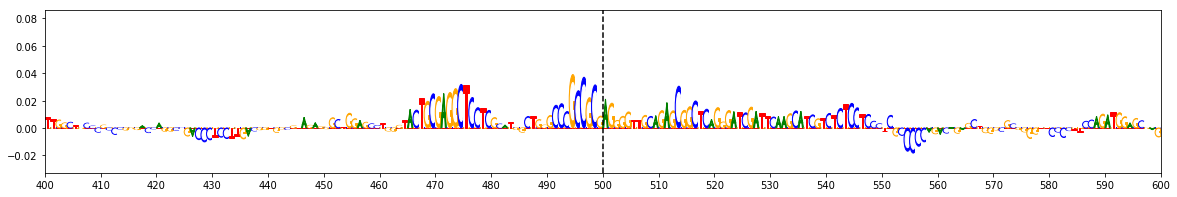

Allele Ratio : 1.636   ||   Allele Difference : 0.4275  ||  ISM Score : 0.6677  ||  deltaSVM Score : 3.8354


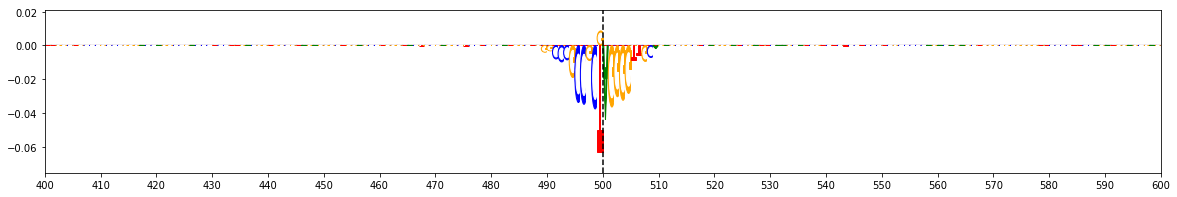


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2696673   ||    chr17 : 46238436 - 46238437   ||    Locus: 156   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  7.22E-21

Coloc:  True

Effect Allele: C   ||  Explain Score: 0.4635   ||  Center / 200bp: 0.6178
Effect Sequence: CAAATACATCTGGTTTTATT


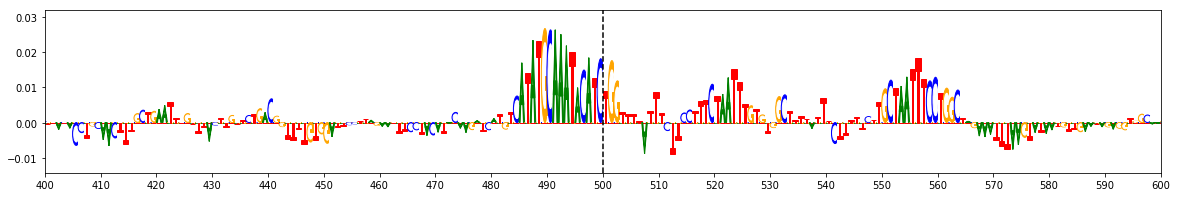

Noneffect Allele: A   ||  Explain Score: 0.2986   ||  Center / 200bp: 0.5104
Noneffect Sequence: CAAATACATATGGTTTTATT


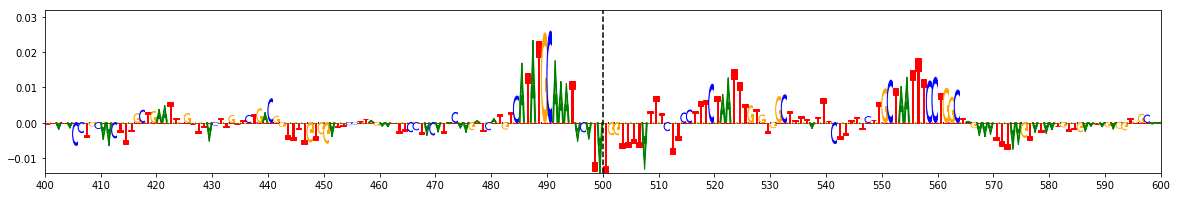

Allele Ratio : 1.5522   ||   Allele Difference : 0.2606  ||  ISM Score : 0.4151  ||  deltaSVM Score : 2.3879


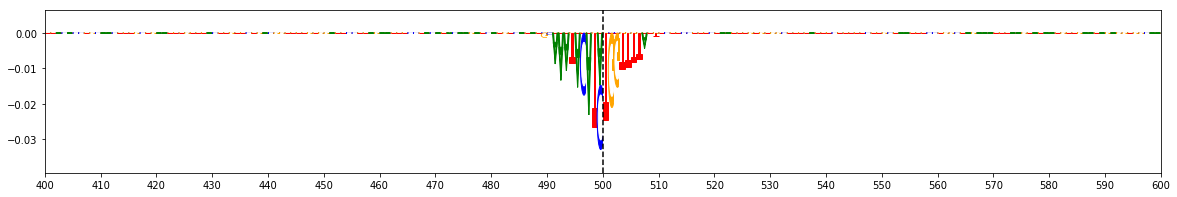


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs35100629   ||    chr5 : 102910380 - 102910381   ||    Locus: 279   ||    IDR Peak: False

GWAS:
Nalls_23andMe 		  1.86E-03

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.5221   ||  Center / 200bp: 0.5439
Effect Sequence: TTGAGAAACGCTCCAACCTC


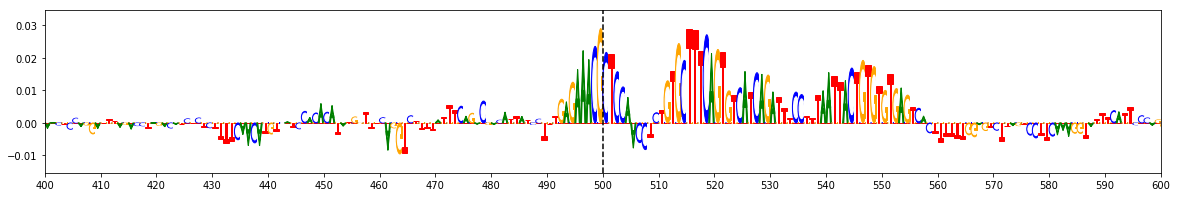

Noneffect Allele: C   ||  Explain Score: 0.305   ||  Center / 200bp: 0.4106
Noneffect Sequence: TTGAGAAACCCTCCAACCTC


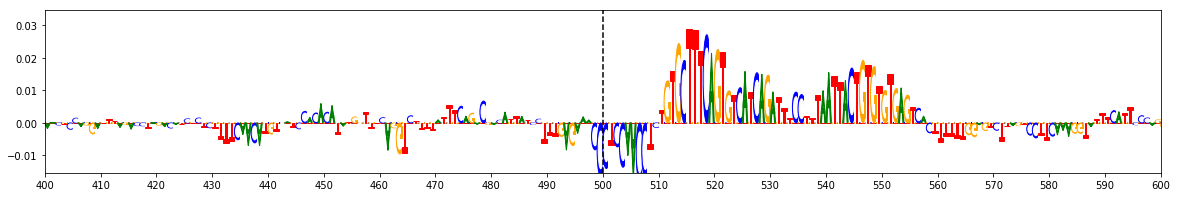

Allele Ratio : 1.7118   ||   Allele Difference : 0.3594  ||  ISM Score : 0.5597  ||  deltaSVM Score : 3.2267


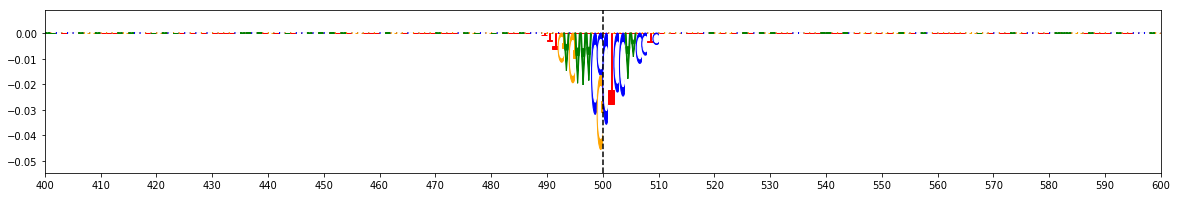


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs36047693   ||    chr17 : 45756457 - 45756458   ||    Locus: 91   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  3.45E-22

Coloc:  True

Effect Allele: G   ||  Explain Score: 0.7243   ||  Center / 200bp: 0.5043
Effect Sequence: CCCCAGCCTGCCTGCCACCC


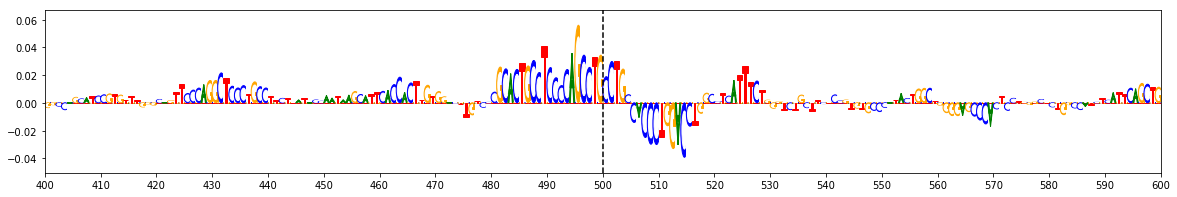

Noneffect Allele: C   ||  Explain Score: 0.4125   ||  Center / 200bp: 0.3684
Noneffect Sequence: CCCCAGCCTCCCTGCCACCC


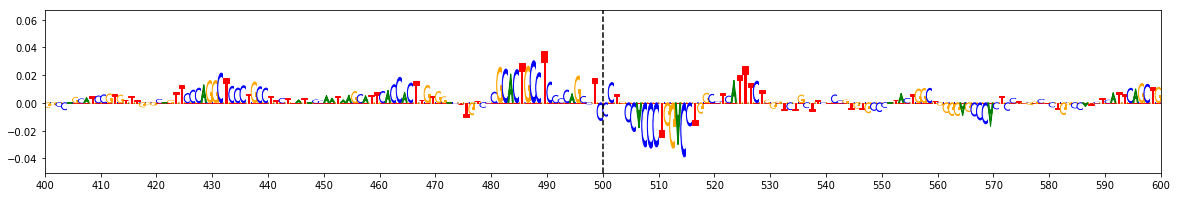

Allele Ratio : 1.7558   ||   Allele Difference : 0.3729  ||  ISM Score : 0.5835  ||  deltaSVM Score : 3.4147


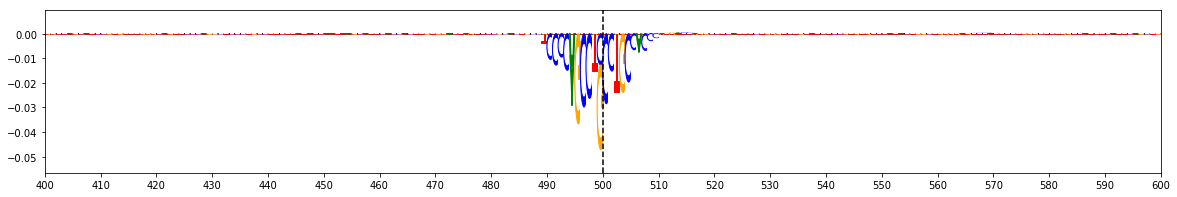


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs199523   ||    chr17 : 46771150 - 46771151   ||    Locus: 162   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  9.49E-14

Coloc:  True

Effect Allele: C   ||  Explain Score: 0.922   ||  Center / 200bp: 0.4181
Effect Sequence: GCCCTCCTGCGCCACCTACA


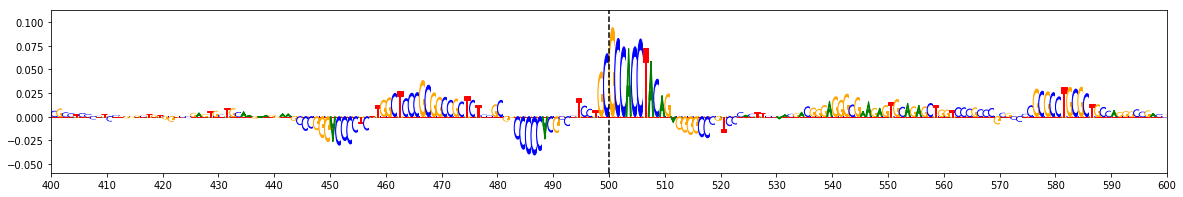

Noneffect Allele: A   ||  Explain Score: 0.4654   ||  Center / 200bp: 0.2658
Noneffect Sequence: GCCCTCCTGAGCCACCTACA


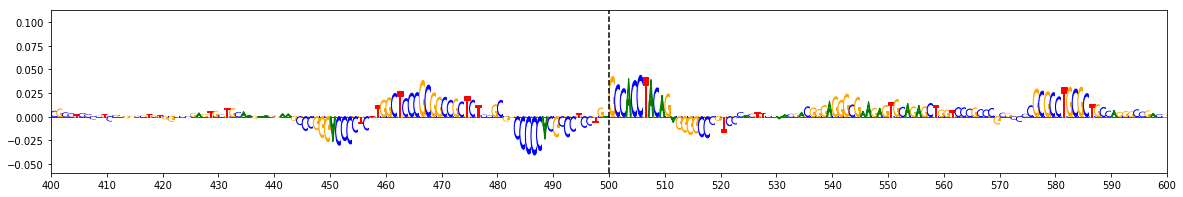

Allele Ratio : 1.9811   ||   Allele Difference : 0.5219  ||  ISM Score : 0.8283  ||  deltaSVM Score : 4.7883


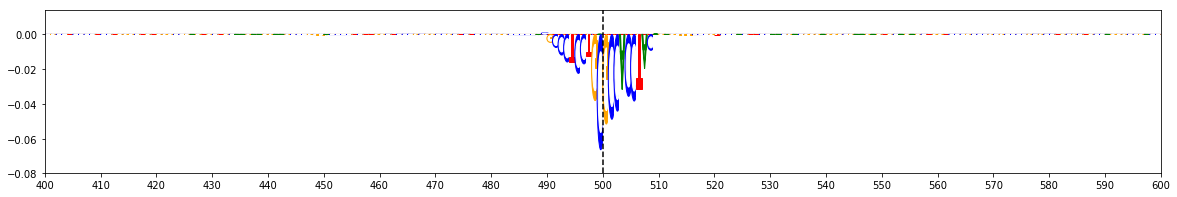


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2668662   ||    chr17 : 46213392 - 46213393   ||    Locus: 155   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  7.45E-22

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.6807   ||  Center / 200bp: 0.7536
Effect Sequence: TCCGCCTGCTGGGTTCACAC


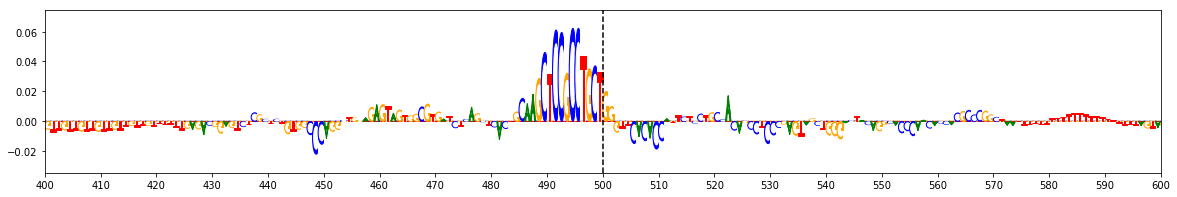

Noneffect Allele: C   ||  Explain Score: 0.6241   ||  Center / 200bp: 0.7371
Noneffect Sequence: TCCGCCTGCCGGGTTCACAC


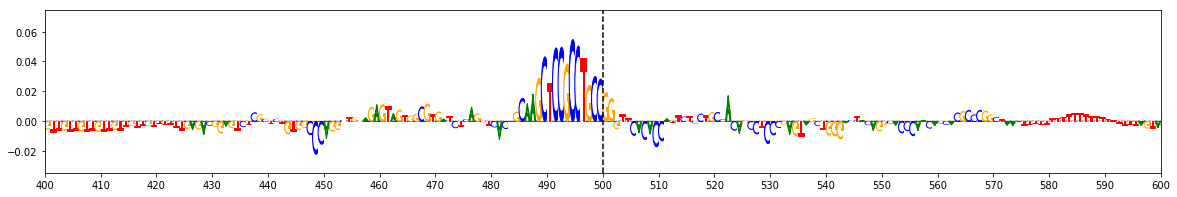

Allele Ratio : 1.0906   ||   Allele Difference : 0.0349  ||  ISM Score : 0.0639  ||  deltaSVM Score : 0.4061


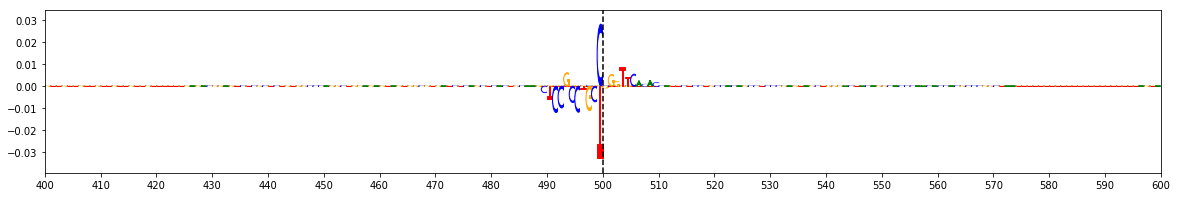


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs1140239   ||    chr16 : 30010080 - 30010081   ||    Locus: 47   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  4.40E-03
Parkinsons_Pankratz_2012 	  NAN

Coloc:  True

Effect Allele: NAN   ||  Explain Score: 0.2042   ||  Center / 200bp: 0.5827
Effect Sequence: CCCCGCCGCACCCGCCGCCC


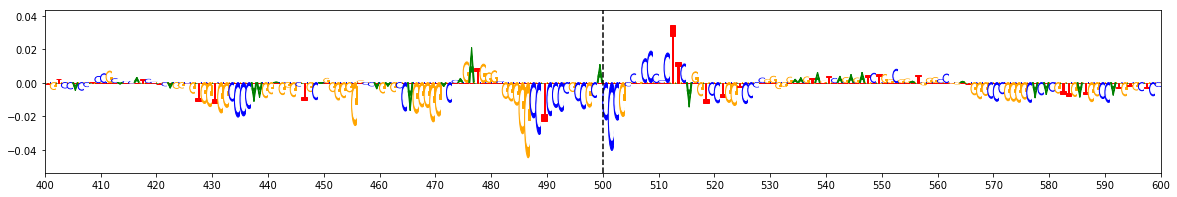

Noneffect Allele: NAN   ||  Explain Score: 0.1466   ||  Center / 200bp: 0.5116
Noneffect Sequence: CCCCGCCGCCCCCGCCGCCC


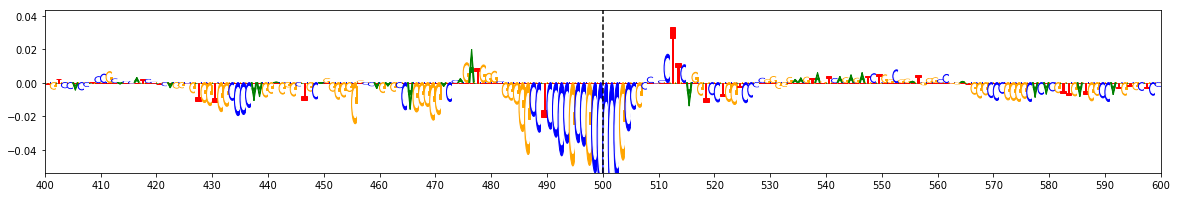

Allele Ratio : 1.3932   ||   Allele Difference : 0.5749  ||  ISM Score : 0.832  ||  deltaSVM Score : 5.7655


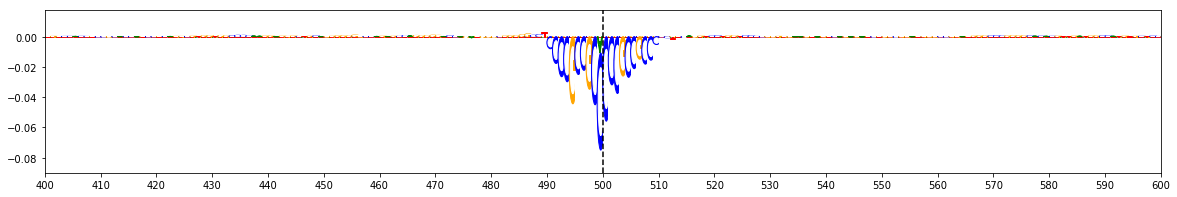


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs3016327   ||    chr11 : 86069405 - 86069406   ||    Locus: 24   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  1.41E-11

Coloc:  False

Effect Allele: T   ||  Explain Score: 1.0516   ||  Center / 200bp: 0.5212
Effect Sequence: CGAGGGCGGTGTGCTGGCGG


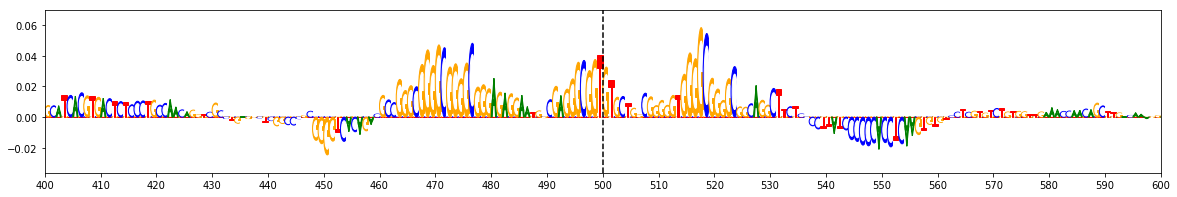

Noneffect Allele: C   ||  Explain Score: 0.6813   ||  Center / 200bp: 0.414
Noneffect Sequence: CGAGGGCGGCGTGCTGGCGG


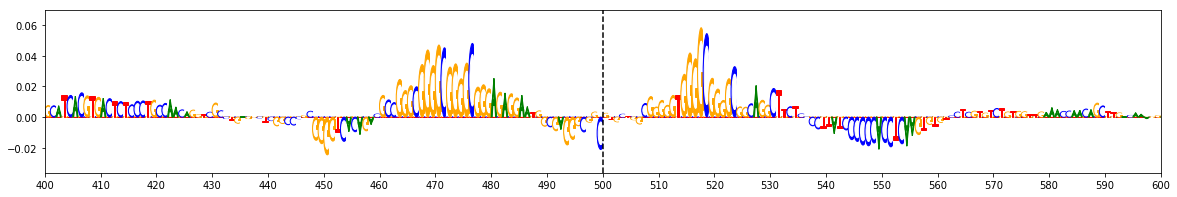

Allele Ratio : 1.5434   ||   Allele Difference : 0.4827  ||  ISM Score : 0.8049  ||  deltaSVM Score : 4.7658


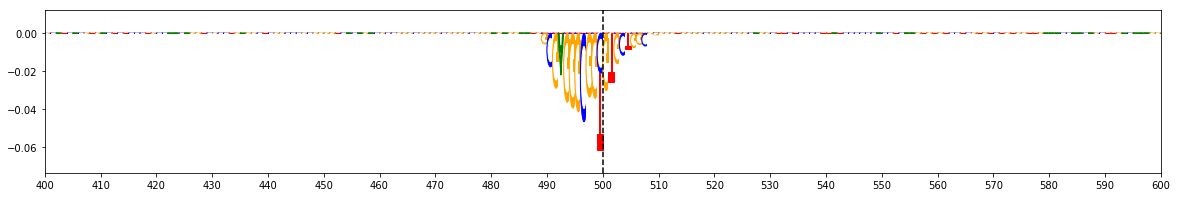


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs113871181   ||    chr17 : 45775366 - 45775367   ||    Locus: 97   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  2.64E-22

Coloc:  True

Effect Allele: G   ||  Explain Score: 0.795   ||  Center / 200bp: 0.6461
Effect Sequence: TATGCAGCTGATGAATCCTC


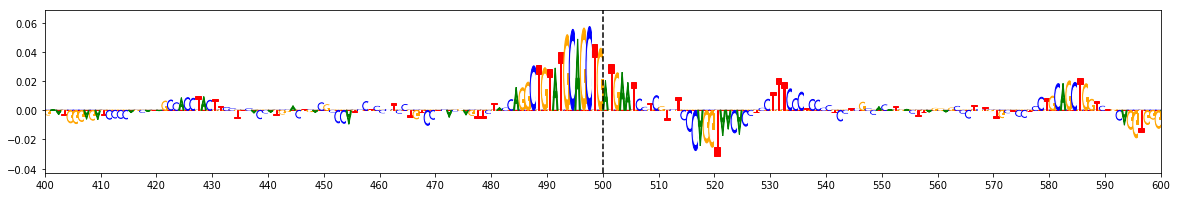

Noneffect Allele: A   ||  Explain Score: 0.6608   ||  Center / 200bp: 0.6026
Noneffect Sequence: TATGCAGCTAATGAATCCTC


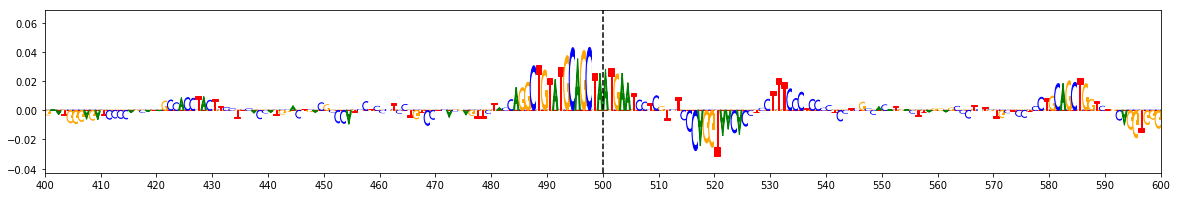

Allele Ratio : 1.203   ||   Allele Difference : 0.1344  ||  ISM Score : 0.2114  ||  deltaSVM Score : 1.249


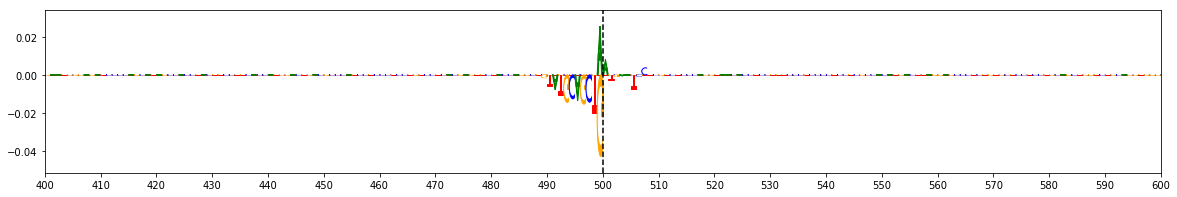


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs34211253   ||    chr17 : 45756707 - 45756708   ||    Locus: 94   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  3.44E-22

Coloc:  True

Effect Allele: G   ||  Explain Score: 0.7332   ||  Center / 200bp: 0.4229
Effect Sequence: ACAGCAAAAGCTTGCTCAGA


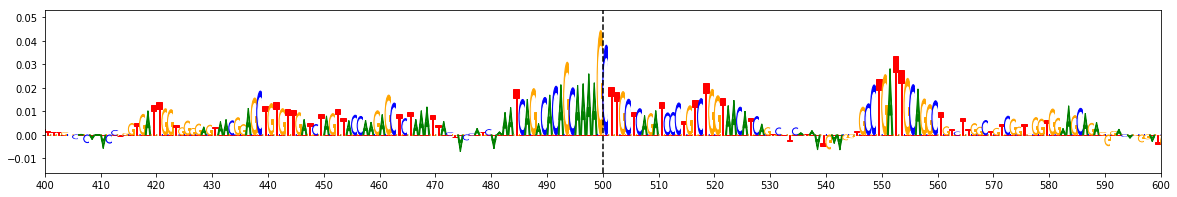

Noneffect Allele: C   ||  Explain Score: 0.4076   ||  Center / 200bp: 0.2893
Noneffect Sequence: ACAGCAAAACCTTGCTCAGA


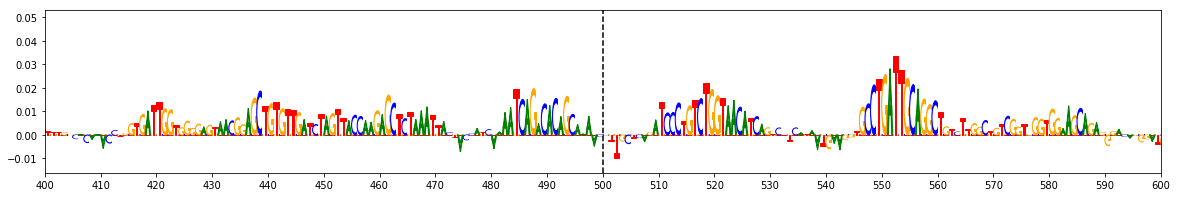

Allele Ratio : 1.7989   ||   Allele Difference : 0.3549  ||  ISM Score : 0.5549  ||  deltaSVM Score : 3.2073


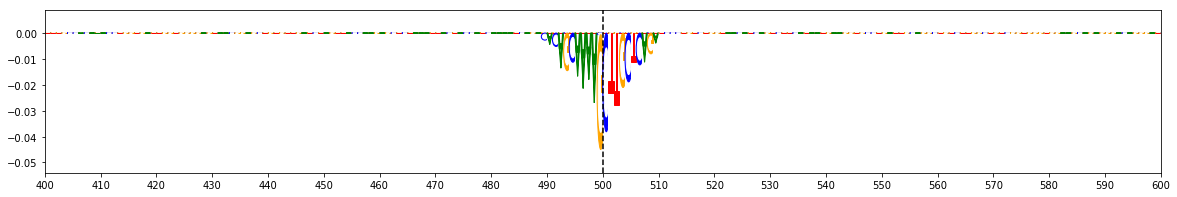


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs858295   ||    chr7 : 23205949 - 23205950   ||    Locus: 295   ||    IDR Peak: False

GWAS:
Chang_23andMe_Parkinsons 	  7.02E-06
Nalls_23andMe 		  7.02E-06

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.7275   ||  Center / 200bp: 0.6091
Effect Sequence: CCCGGCAGAGAGAGCTCGAA


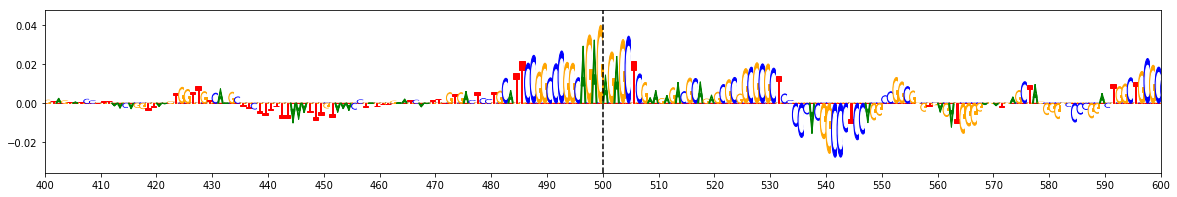

Noneffect Allele: A   ||  Explain Score: 0.5835   ||  Center / 200bp: 0.5551
Noneffect Sequence: CCCGGCAGAAAGAGCTCGAA


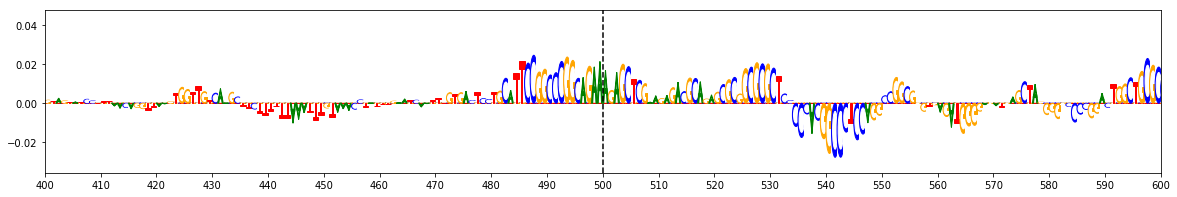

Allele Ratio : 1.2468   ||   Allele Difference : 0.144  ||  ISM Score : 0.2285  ||  deltaSVM Score : 1.2968


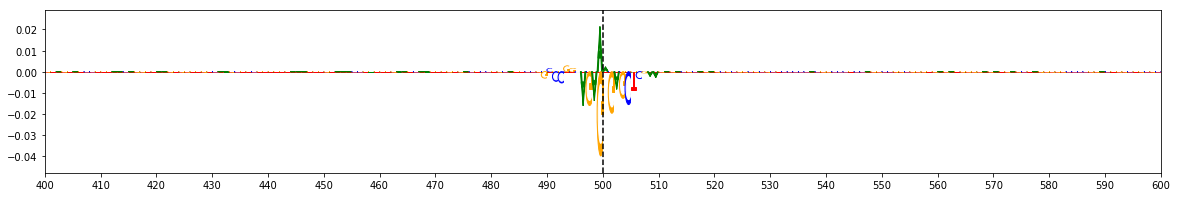


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs3776863   ||    chr5 : 102992164 - 102992165   ||    Locus: 282   ||    IDR Peak: False

GWAS:
Nalls_23andMe 		  5.24E-03

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.8724   ||  Center / 200bp: 0.667
Effect Sequence: AGGTAACCAGGATCCTGTGG


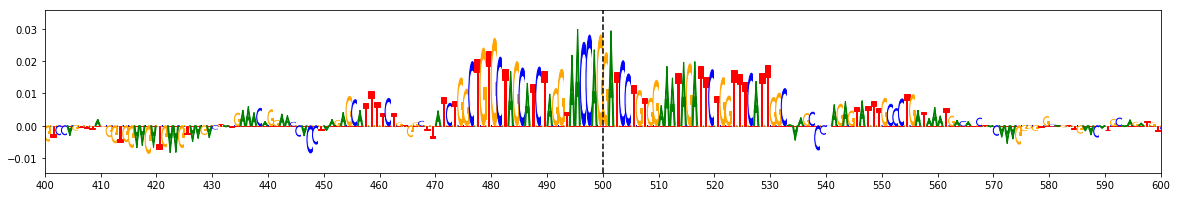

Noneffect Allele: C   ||  Explain Score: 0.7672   ||  Center / 200bp: 0.6363
Noneffect Sequence: AGGTAACCACGATCCTGTGG


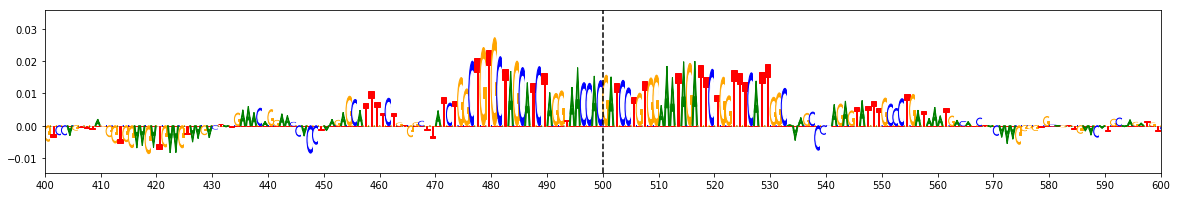

Allele Ratio : 1.1372   ||   Allele Difference : 0.1053  ||  ISM Score : 0.1603  ||  deltaSVM Score : 0.9812


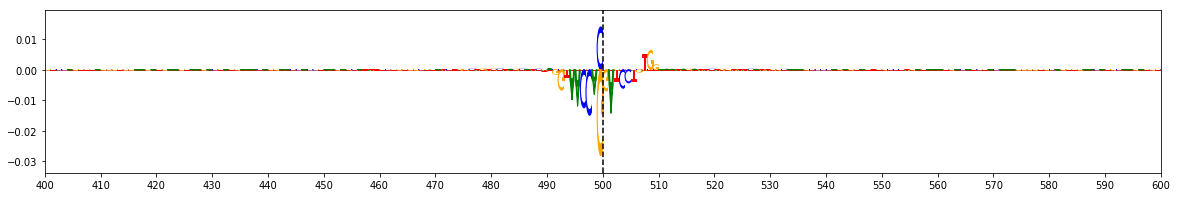


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs10136545   ||    chr14 : 54886144 - 54886145   ||    Locus: 35   ||    IDR Peak: False

GWAS:
Chang_23andMe_Parkinsons 	  3.13E-07
Nalls_23andMe 		  3.13E-07

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.4308   ||  Center / 200bp: 0.4919
Effect Sequence: TCCTGACAATCTGGGAGAAG


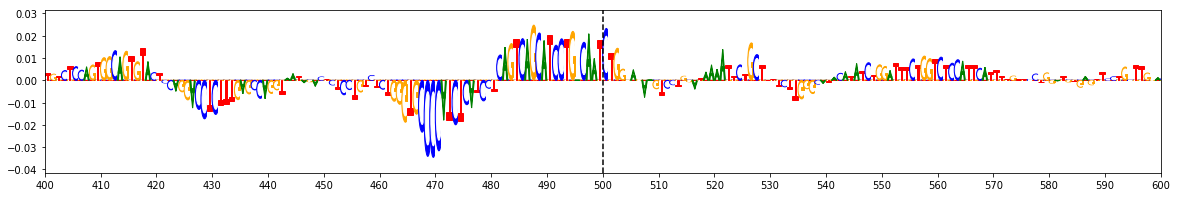

Noneffect Allele: C   ||  Explain Score: 0.2829   ||  Center / 200bp: 0.3886
Noneffect Sequence: TCCTGACAACCTGGGAGAAG


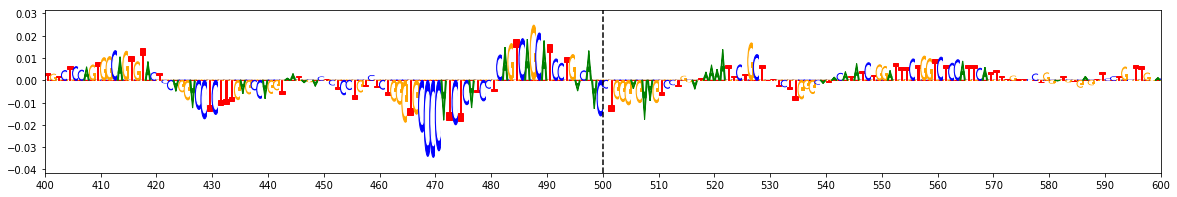

Allele Ratio : 1.5231   ||   Allele Difference : 0.267  ||  ISM Score : 0.4179  ||  deltaSVM Score : 2.4297


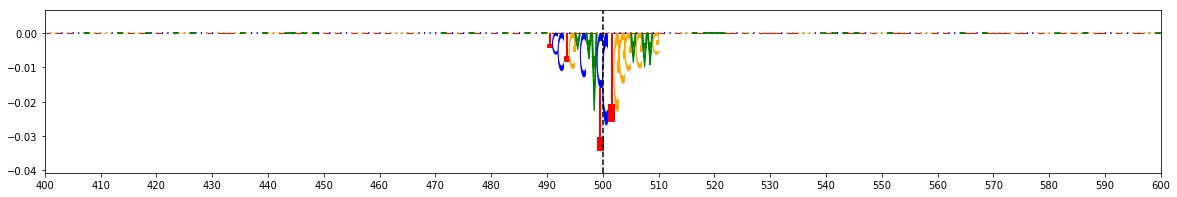


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [8]:
for idx in pos_snps.index[:20]:
    #for idx in [60]:
    print('RSID:', pos_snps.at[idx, 'rsid'],
          '  ||   ', pos_snps.at[idx, 'chr'], ':', pos_snps.at[idx, 'start'], '-', pos_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', idx, '  ||   ', 'IDR Peak:', pos_snps.at[idx, 'idr_peak'])
    
    print()
    
    print('GWAS:')
    
    for i in pos_snps.at[idx, 'all_gwas']:
        entry = i.split(':')
        if 'Lambert' in entry[0] or 'Pankratz' in entry[0] or 'Chang' in entry[0]:
            print(entry[0], '\t', entry[1])
        else:
            print(entry[0], '\t\t', entry[1])
    
    print()
        
    print("Coloc: ", pos_snps.at[idx, 'coloc'])
    
    print()
    
    print('Effect Allele:', pos_snps.at[idx, 'effect'], '  ||  Explain Score:', round(pos_snps.at[idx, 'effect_center'], 4), '  ||  Center / 200bp:', round(pos_snps.at[idx, 'effect_ratio'], 4))
    print('Effect Sequence:', effect_seqs[idx][490:510])
    
    ylim = plot_weights(merged_effect_scores[idx], subticks_frequency=10, xlim=(400,600))

    print('Noneffect Allele:', pos_snps.at[idx, 'noneffect'], '  ||  Explain Score:', round(pos_snps.at[idx, 'noneffect_center'], 4), '  ||  Center / 200bp:', round(pos_snps.at[idx, 'noneffect_ratio'], 4))
    print('Noneffect Sequence:', noneffect_seqs[idx][490:510])
    
    a = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('Allele Ratio :', round(pos_snps.at[idx, 'allele_ratio'], 4), '  ||   Allele Difference :', round(pos_snps.at[idx, 'allele_diff'], 4),
          ' ||  ISM Score :', round(pos_snps.at[idx, 'ism_score'], 4), ' ||  deltaSVM Score :', round(pos_snps.at[idx, 'delta_score'], 4))
    
    a = plot_weights(merged_noneffect_scores[idx] - merged_effect_scores[idx], subticks_frequency=10, xlim=(400,600))
    
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()